In [1]:
# To support both python 2 and python 3
from __future__ import print_function, division, unicode_literals
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

# Usual imports
import numpy as np
import os
import cv2
import warnings
from os.path import join as path_join
from tqdm import tqdm
import json
tqdm.pandas()
import itertools
from datetime import datetime

from itertools import combinations, product

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option("display.max_columns", 100)

# while not os.getcwd().endswith("ml"):
#     os.chdir(os.path.abspath(os.path.join(os.pardir)))
print("Working dir:", os.getcwd())

from Common.analysis.analysis_tools import calculate_acceptable_precision_error
from Common.data_manipulation.pandas_tools import save_dataframe, add_face_id, load_df, separate_df_based_on_column_range, add_image_id
from Common.data_manipulation.dictionary_tools import convert_dict_lists_to_list_of_dicts, create_or_append_to_dict_of_lists, nested_dict_add_element

# from Common.paths.dataset_paths import 
from Common.image_tools.image_loading import load_image
from Common.image_tools.cropping import crop_box
from Common.image_tools.resizer import resize_image

from Common.data_manipulation.pickler import write_pickle, load_pickle

from Common.machine_learning_tools.model_tools.tensoflow_model_tools import initialize_memory_growth

from Common.miscellaneous import print_indexed_list, print_fraction, verbose_print
from Common.visualizations.image_visualizations import show_image, show_images, draw_pose, draw_bounding_box, draw_landmarks, draw_confidences
from Common.visualizations.figure_plotting import plot_histogram, plot_multiple_histograms, plot_scatter_historgram, plot_CED_curve, plot_multiple_CED_curves, plot_xy_curves, plot_xs_and_ys, plot_scatter_historgram

Working dir: D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT


In [2]:
experiments_path = path_join(os.getcwd(), "experiments")
data_filtering_path = path_join(os.getcwd(), "data_filtering")

In [3]:
train_csv_name = "training.csv"
results_csv_name = "results.csv"

MIN_CORRECT_LOSS = 0.3

In [4]:
from matplotlib.ticker import MultipleLocator

MARKER_LIST = ['o', 'v', '^', '<', '>', 's', 'p', 'P', '*', 'X', 'D', 'H', '+', 'x']
ALL_COLORS = list(matplotlib.colors.BASE_COLORS.keys())[:3] + list(matplotlib.colors.BASE_COLORS.keys())[3:5:-1] + list(matplotlib.colors.BASE_COLORS.keys())[5:7] + \
             list(matplotlib.colors.TABLEAU_COLORS.keys()) + list(matplotlib.colors.CSS4_COLORS.keys())
DEFAULT_PLOT_SIZE = (22, 8)

def plot_multiple_CED_curves(multiple_CED, thresholds, names, log_scale=False, marker=True, **kwargs):
    figure, ax = plt.subplots(figsize=kwargs.get('fig_size', DEFAULT_PLOT_SIZE), clear=True)
    ax.grid(True, which='both')

    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks(np.arange(0, 1.01, 0.05), minor=True)
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))

#     ax.set_xticks(thresholds, minor=True)
#     ax.xaxis.set_minor_locator(MultipleLocator(thresholds[2] - thresholds[0]))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.set_xlim(-0.02, 1.02)

    if log_scale:
        ax.set_yscale("log")
        ax.set_xscale("log")

    for i, error_percents in enumerate(multiple_CED):
        if len(thresholds) == len(error_percents):
            this_marker_index = MARKER_LIST[i % len(MARKER_LIST)] if marker else None
            ax.plot(thresholds, error_percents, marker=this_marker_index)

    plt.legend(names)

    if kwargs.get('axis_labels', None) is not None:
        axis_labels = kwargs.get('axis_labels', None)
        plt.xlabel(axis_labels[0])
        plt.ylabel(axis_labels[1])
    else:
        plt.xlabel('Threshold')
        plt.ylabel('Percent')

In [5]:
def categorical_metric_analysis(df, categorical_columns, metric_column='test_acc', do_plot_CDFs=True, marker=True, fig_size=(22, 8), log_scale=False):
    uniques = [sorted(pd.unique(df[categorical_column])) for categorical_column in categorical_columns]
    
    categorical_accuracies = {}

    if do_plot_CDFs:
#         thresholds = thresholds if thresholds is not None else np.linspace(0, 1, 51)
        thresholds = sorted(pd.unique(df[metric_column]))
        cdfs = []
        cdfs_names = []
        
    for permutation in product(*uniques):
        print_string = ""

        unique_df = df.copy()
        for clmn, perm in zip(categorical_columns, permutation):
            unique_df = unique_df.loc[unique_df[clmn] == perm]

            print_string += "{}={} | ".format(clmn, perm)

        unique_size = len(unique_df)
        
        if unique_size == 0:
            continue
            
        mean_acc = unique_df[metric_column].mean()
        
        nested_dict_add_element(categorical_accuracies, permutation, mean_acc)
        
        if do_plot_CDFs:
            cdf = calculate_acceptable_precision_error(unique_df[metric_column], thresholds, absolute=True)
            cdfs.append(cdf)
            cdfs_names.append(print_string[:-3])

        print_string += "size: {:2d} | {}: {:.4f}".format(unique_size, metric_column, mean_acc)

        print(print_string)
        
    if do_plot_CDFs:
        plot_multiple_CED_curves(cdfs, thresholds, cdfs_names, axis_labels=['Tikslumas', "Tikimybė"], marker=marker, fig_size=fig_size, log_scale=log_scale)
        
    return categorical_accuracies

In [6]:
def df_to_dict_of_losses(df):
    dfs = dict(tuple(df.groupby('index')['loss']))
    dict_of_losses = {key: np.array(list(value)) for key, value in dfs.items()}
    
    return dict_of_losses

In [7]:
experiment_types = sorted(list(os.listdir(experiments_path)))
print_indexed_list(experiment_types)

0 CIFAR-10-LeNet
1 MNIST-LeNet1
2 MNIST-LeNet2
3 custom


In [20]:
experiment_type_idx = 1

# experiment_type_path = path_join(experiments_path, experiment_types[experiment_type_idx])
# experiment_type_path = path_join(experiments_path, experiment_types[experiment_type_idx], "min_agreggation-fix")
experiment_type_path = path_join(experiments_path, experiment_types[experiment_type_idx], "1st_look_hardness")
experiments = sorted(list(os.listdir(experiment_type_path)))
print_indexed_list(experiments)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\Igno\\Reikalingi\\KTU Magistras\\Magistrinis\\OoMLeT\\experiments\\MNIST-LeNet1\\1st_look_hardness'

In [206]:
exp_idx = 0

experiment_path = path_join(experiment_type_path, experiments[exp_idx])
experiment_path

'D:\\Igno\\Reikalingi\\KTU Magistras\\Magistrinis\\OoMLeT\\experiments\\MNIST-LeNet1\\1st_look_hardness\\1st_look_hardness-ucb-k10-ftk3'

In [207]:
results_csv_name = "results.csv"
csv_fullname = path_join(experiment_path, results_csv_name)

res_df = load_df(csv_fullname)
res_df

Loaded a Dataframe with shape 100 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\1st_look_hardness\1st_look_hardness-ucb-k10-ftk3\results.csv
at  2024-05-16 19:25:46.352054


,learning_rate,reg_param,conv1_depth,pool1_size,conv2_depth,pool2_size,window_size,fc_depth,dropout_rate,val_acc,test_acc,time_spent,train_set_size
0,0.004682,0.069916,16,3,16,3,4,176,0.338539,0.9910,0.9881,66,55000
1,0.001154,0.419225,200,2,248,3,7,800,0.112158,0.9982,0.9947,439,55000
2,0.002010,0.630410,200,3,224,3,6,800,0.265470,1.0000,0.9954,232,55000
3,0.038292,1.000000,216,3,104,3,3,800,1.000000,0.1068,0.1135,46,55000
4,0.003505,0.000000,8,3,8,3,4,104,0.248638,0.9580,0.9584,18,9382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000100,0.000000,192,2,264,3,6,800,0.100000,0.9864,0.9884,148,16543
96,0.000100,0.000000,56,2,48,2,8,152,1.000000,0.9888,0.9873,51,16543
97,0.000100,0.000000,224,3,240,3,6,816,0.100000,0.9854,0.9871,93,16543
98,0.000100,0.000000,216,3,232,3,7,792,0.100000,0.9862,0.9889,110,16543


In [208]:
res_df.head(60)

,learning_rate,reg_param,conv1_depth,pool1_size,conv2_depth,pool2_size,window_size,fc_depth,dropout_rate,val_acc,test_acc,time_spent,train_set_size
0,0.004682,0.069916,16,3,16,3,4,176,0.338539,0.9910,0.9881,66,55000
1,0.001154,0.419225,200,2,248,3,7,800,0.112158,0.9982,0.9947,439,55000
2,0.002010,0.630410,200,3,224,3,6,800,0.265470,1.0000,0.9954,232,55000
3,0.038292,1.000000,216,3,104,3,3,800,1.000000,0.1068,0.1135,46,55000
4,0.003505,0.000000,8,3,8,3,4,104,0.248638,0.9580,0.9584,18,9382
5,0.002521,0.256411,24,2,96,3,4,144,0.296157,0.9946,0.9945,22,9382
6,0.001388,0.062492,96,3,48,3,8,152,0.272991,0.9972,0.9951,33,11109
7,0.000100,1.000000,56,2,96,3,10,232,1.000000,0.9880,0.9864,45,11109
8,0.050000,0.000000,120,3,128,2,2,192,0.100000,0.0956,0.1009,7,11109
9,0.000100,1.000000,32,2,56,3,10,160,1.000000,0.9836,0.9846,52,11109


In [209]:
res_df.sort_values('test_acc', ascending=False).head(60)

,learning_rate,reg_param,conv1_depth,pool1_size,conv2_depth,pool2_size,window_size,fc_depth,dropout_rate,val_acc,test_acc,time_spent,train_set_size
2,0.002010,0.630410,200,3,224,3,6,800,0.265470,1.0000,0.9954,232,55000
6,0.001388,0.062492,96,3,48,3,8,152,0.272991,0.9972,0.9951,33,11109
71,0.002965,0.516533,64,2,136,3,9,160,0.355793,0.9990,0.9949,89,16543
60,0.001787,0.441509,208,3,240,3,5,824,0.441285,0.9990,0.9949,74,16543
29,0.003348,0.900029,32,2,120,2,5,144,0.193109,0.9964,0.9948,26,11109
1,0.001154,0.419225,200,2,248,3,7,800,0.112158,0.9982,0.9947,439,55000
38,0.003187,0.079277,72,3,96,2,7,152,0.502353,0.9994,0.9947,39,16543
79,0.002784,0.724298,64,2,136,2,10,184,0.455488,0.9990,0.9946,81,16543
5,0.002521,0.256411,24,2,96,3,4,144,0.296157,0.9946,0.9945,22,9382
35,0.000547,0.758059,72,3,72,3,9,136,0.441569,0.9976,0.9942,47,16543


std: 0.2756892082381898


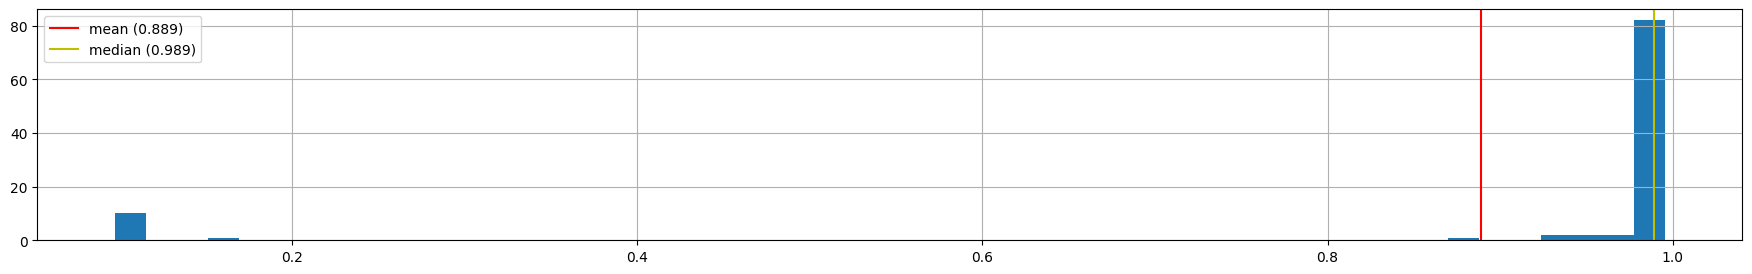

<Figure size 640x480 with 0 Axes>

In [210]:
plot_histogram(res_df['test_acc'], fig_size=(22, 3))

In [259]:
# median_acc = res_df['test_acc'].quantile(0.7)
# good_df = res_df.loc[res_df['test_acc'] >= median_acc]
# good_indice = list(good_df.index)
# good_df

In [260]:
# res_df['test_acc'].quantile(0.7)

## Concat results csvs

In [8]:
def parse_folder_arguments(folder_name):
    split_folder_name = folder_name.split('-')
    
    args_dict = {}
    args_dict['filter_method'] = split_folder_name[0]
    args_dict['acquisition'] = split_folder_name[1]
    
    for folder_substring in split_folder_name[2:]:
        if len(folder_substring) > 1:
            for i in range(1, len(folder_substring)):
                arg_name = folder_substring[:i]
                arg_value = folder_substring[i:]

                if not arg_name.isnumeric() and arg_value.isnumeric():
                    break
        elif folder_substring.isnumeric():
            arg_name = 'repetition'
            arg_value = folder_substring
                
        args_dict[arg_name] = int(arg_value)
        
    if not 'repetition' in args_dict:
        args_dict['repetition'] = 1
        
    return args_dict

In [9]:
experiment_types = sorted(list(os.listdir(experiments_path)))
print_indexed_list(experiment_types)

0 CIFAR-10-LeNet
1 MNIST-LeNet1
2 MNIST-LeNet2
3 custom


In [10]:
experiment_dataset_idx = 0

# experiment_dataset_path = path_join(experiments_path, experiment_types[experiment_dataset_idx], "1st-mato")
# experiment_dataset_path = path_join(experiments_path, experiment_types[experiment_dataset_idx], "min_agreggation-fix")
# experiment_dataset_path = path_join(experiments_path, experiment_types[experiment_dataset_idx], "topk")
# experiment_dataset_path = path_join(experiments_path, experiment_types[experiment_dataset_idx])
experiment_dataset_path = experiments_path
experiments = sorted(list(os.listdir(experiment_dataset_path)))
print_indexed_list(experiments)

0 CIFAR-10-LeNet
1 MNIST-LeNet1
2 MNIST-LeNet2
3 custom


In [31]:
result_dfs = []
experiment_index = 0

for root, subdirs, folder_contents in os.walk(experiment_dataset_path):
    if results_csv_name in folder_contents:
        subroot, folder_name = os.path.split(root)
        experiment_type = os.path.split(subroot)[1]
        
        args_dict = parse_folder_arguments(folder_name)
        
#         print(folder_name, folder_contents)
#         print(folder_name, args_dict)
        
        result_csv_name = path_join(root, results_csv_name)
        result_df = load_df(result_csv_name)
        
#         result_df['experiment_type'] = experiment_type
        result_df['experiment_type'] = root.split('\\')[7]
        result_df['exp_index'] = experiment_index
        result_df['run_idx'] = result_df.index
        result_df['root'] = root[45+18:]
        
        for arg_name, arg_value in args_dict.items():
            result_df[arg_name] = arg_value
            
        result_dfs.append(result_df)
        experiment_index += 1
        
#         display(result_df)
        
full_res_df = pd.concat(result_dfs)
full_res_df

Loaded a Dataframe with shape 100 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb-k10-ftk3\results.csv
at  2024-05-24 12:53:27.104132
Loaded a Dataframe with shape 100 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb-k10-ftk5\results.csv
at  2024-05-24 12:53:27.122630
Loaded a Dataframe with shape 17 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb-k25-ftk2\results.csv
at  2024-05-24 12:53:27.141133
Loaded a Dataframe with shape 100 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb-k25-ftk3\results.csv
at  2024-05-24 12:53:27.147631
Loaded a Dataframe with shape 100 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb-k25-ftk5\results.csv
at

at  2024-05-24 12:53:27.688131
Loaded a Dataframe with shape 20 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\min_agreggation-2\example_forgetting-ucb-k10-ff3-fq05\results.csv
at  2024-05-24 12:53:27.693131
Loaded a Dataframe with shape 20 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\min_agreggation-2\example_forgetting-ucb-k10-ff5-fq05\results.csv
at  2024-05-24 12:53:27.700631
Loaded a Dataframe with shape 20 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\min_agreggation-2\example_forgetting-ucb-k25-ff3-fq05\results.csv
at  2024-05-24 12:53:27.706631
Loaded a Dataframe with shape 20 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\min_agreggation-2\example_forgetting-ucb-k25-ff5-fq05\results.csv
at  2024-05-24 12:53:27.713131
Loaded a Dataframe with shape 20 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLe

Loaded a Dataframe with shape 100 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\LeNet1-05-16\1st_look_hardness-ucb-k25-ftk3\results.csv
at  2024-05-24 12:53:28.281131
Loaded a Dataframe with shape 100 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\LeNet1-05-16\1st_look_hardness-ucb-k40-ftk3\results.csv
at  2024-05-24 12:53:28.298629
Loaded a Dataframe with shape 100 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\saul-1\1st_look_hardness-ucb-k25-ftk3-2\results.csv
at  2024-05-24 12:53:28.316129
Loaded a Dataframe with shape 1 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\saul-1\1st_look_hardness-ucb-k40-ftk3\results.csv
at  2024-05-24 12:53:28.332630
Loaded a Dataframe with shape 4 × 13 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\MNIST-LeNet1\topk\example_forgetting-ucb-k10-ftk10\results.csv
at  2024-05

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,root,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.011556,0.011197,3.0,32,64,112.0,80.0,472,elu,BatchNorm,1.0000,0.6863,151.0,45000.0,CIFAR-10-LeNet,0,0,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.076464,0.526661,3.0,32,64,112.0,80.0,256,elu,None,0.0000,0.0000,0.0,45000.0,CIFAR-10-LeNet,0,1,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001154,0.905991,2.0,24,64,120.0,80.0,480,elu,Dropout,0.1894,0.1912,16.0,45000.0,CIFAR-10-LeNet,0,2,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005881,0.526295,2.0,16,40,80.0,112.0,968,tanh,BatchNorm,0.8038,0.6661,121.0,45000.0,CIFAR-10-LeNet,0,3,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.137176,0.341528,3.0,24,56,72.0,104.0,456,tanh,BatchNorm,1.0000,0.7291,85.0,45000.0,CIFAR-10-LeNet,0,4,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000851,NaN,NaN,352,352,NaN,NaN,1000,lrelu,NaN,0.9788,0.9710,133.0,2550.0,MNIST-LeNet2,177,95,\MNIST-LeNet2\saul-1\example_forgetting-ucb-k2...,example_forgetting,ucb,25.0,5.0,1,NaN,NaN,0.976970,NaN,NaN,0.124530,NaN,NaN,NaN,Adam,1.0,NaN
96,0.001200,NaN,NaN,184,296,NaN,NaN,680,elu,NaN,0.9868,0.9727,53.0,2550.0,MNIST-LeNet2,177,96,\MNIST-LeNet2\saul-1\example_forgetting-ucb-k2...,example_forgetting,ucb,25.0,5.0,1,NaN,NaN,0.001576,NaN,NaN,0.263409,NaN,NaN,NaN,RMSProp,1.0,NaN
97,0.000225,NaN,NaN,160,296,NaN,NaN,672,lrelu,NaN,0.9912,0.9791,89.0,2550.0,MNIST-LeNet2,177,97,\MNIST-LeNet2\saul-1\example_forgetting-ucb-k2...,example_forgetting,ucb,25.0,5.0,1,NaN,NaN,0.187540,NaN,NaN,0.050132,NaN,NaN,NaN,RMSProp,1.0,NaN
98,0.000814,NaN,NaN,168,288,NaN,NaN,672,elu,NaN,0.9976,0.9894,117.0,2550.0,MNIST-LeNet2,177,98,\MNIST-LeNet2\saul-1\example_forgetting-ucb-k2...,example_forgetting,ucb,25.0,5.0,1,NaN,NaN,0.327417,NaN,NaN,0.721500,NaN,NaN,NaN,Adam,0.0,NaN


In [32]:
# result_dfs = []

# for task_name in os.listdir(experiments_path):
#     task_exps_path = path_join(experiments_path, task_name)
#     for experiment_name in os.listdir(task_exps_path):
        
#         args_dict = parse_folder_arguments(experiment_name)
        
#         if len(split_exp_name) > 2:
#             result_csv_name = path_join(task_exps_path, experiment_name, "results.csv")
            
#             if os.path.isfile(result_csv_name):
#                 result_df = load_df(result_csv_name)
                
#                 result_df['task'] = task_name
#                 result_df['parameter'] = split_exp_name[-2]
#                 result_df['num'] = split_exp_name[-1]
                
#                 result_dfs.append(result_df)
                
#             else:
#                 print("No result file in ", result_csv_name)
                
# #         elif "Stage" in experiment_name:
# #             for experiment_name in os.listdir(task_exps_path):
# #                 split_exp_name = experiment_name.split('-')

# #                 if len(split_exp_name) > 2:
# #                     result_csv_name = path_join(task_exps_path, experiment_name, "results.csv")

# #                     if os.path.isfile(result_csv_name):
# #                         result_df = load_df(result_csv_name)

# #                         result_df['task'] = task_name
# #                         result_df['parameter'] = split_exp_name[-2]
# #                         result_df['num'] = split_exp_name[-1]

# #                         result_dfs.append(result_df)

# #                     else:
# #                         print("No result file in ", result_csv_name)
            
# full_res_df = pd.concat(result_dfs)
# full_res_df

## Results csvs analysis

In [33]:
pd.value_counts(full_res_df['experiment_type'])

CIFAR-10-LeNet    3294
MNIST-LeNet1      2266
MNIST-LeNet2      1818
Name: experiment_type, dtype: int64

In [22]:
full_res_df.replace(
    {'experiment_type': {'max_agreggation': 'CIFAR-10', 'min_agreggation-fix': 'CIFAR-10', 'min_agreggation': 'CIFAR-10', 'min_agreggation-2': 'CIFAR-10', '1st-mato': 'CIFAR-10',  '2nd-mato': 'CIFAR-10', 
                         'topk': 'MNIST-LeNet1', 'frequency': 'MNIST-LeNet1', 'LeNet1-Stage 1': 'MNIST-LeNet1', 'LeNet1-05-16': 'MNIST-LeNet1', 
                         'LeNet2-Stage 1': 'MNIST-LeNet2', 'LeNet2-05-15': 'MNIST-LeNet2', 'LeNet2-05-16': 'MNIST-LeNet2'}}, 
    inplace=True
)
pd.value_counts(full_res_df['experiment_type'])

CIFAR-10        3294
MNIST-LeNet1    2165
MNIST-LeNet2    1318
saul-1           601
Name: experiment_type, dtype: int64

In [34]:
pd.value_counts(full_res_df['filter_method'])

1st_look_hardness     3640
example_forgetting    3038
MNIST                  700
Name: filter_method, dtype: int64

In [35]:
full_res_df.replace(
    {'filter_method': {'MNIST': 'example_forgetting'}}, inplace=True
)
pd.value_counts(full_res_df['filter_method'])

example_forgetting    3738
1st_look_hardness     3640
Name: filter_method, dtype: int64

In [36]:
full_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,root,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.011556,0.011197,3.0,32,64,112.0,80.0,472,elu,BatchNorm,1.0000,0.6863,151.0,45000.0,CIFAR-10-LeNet,0,0,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.076464,0.526661,3.0,32,64,112.0,80.0,256,elu,None,0.0000,0.0000,0.0,45000.0,CIFAR-10-LeNet,0,1,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001154,0.905991,2.0,24,64,120.0,80.0,480,elu,Dropout,0.1894,0.1912,16.0,45000.0,CIFAR-10-LeNet,0,2,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005881,0.526295,2.0,16,40,80.0,112.0,968,tanh,BatchNorm,0.8038,0.6661,121.0,45000.0,CIFAR-10-LeNet,0,3,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.137176,0.341528,3.0,24,56,72.0,104.0,456,tanh,BatchNorm,1.0000,0.7291,85.0,45000.0,CIFAR-10-LeNet,0,4,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000851,NaN,NaN,352,352,NaN,NaN,1000,lrelu,NaN,0.9788,0.9710,133.0,2550.0,MNIST-LeNet2,177,95,\MNIST-LeNet2\saul-1\example_forgetting-ucb-k2...,example_forgetting,ucb,25.0,5.0,1,NaN,NaN,0.976970,NaN,NaN,0.124530,NaN,NaN,NaN,Adam,1.0,NaN
96,0.001200,NaN,NaN,184,296,NaN,NaN,680,elu,NaN,0.9868,0.9727,53.0,2550.0,MNIST-LeNet2,177,96,\MNIST-LeNet2\saul-1\example_forgetting-ucb-k2...,example_forgetting,ucb,25.0,5.0,1,NaN,NaN,0.001576,NaN,NaN,0.263409,NaN,NaN,NaN,RMSProp,1.0,NaN
97,0.000225,NaN,NaN,160,296,NaN,NaN,672,lrelu,NaN,0.9912,0.9791,89.0,2550.0,MNIST-LeNet2,177,97,\MNIST-LeNet2\saul-1\example_forgetting-ucb-k2...,example_forgetting,ucb,25.0,5.0,1,NaN,NaN,0.187540,NaN,NaN,0.050132,NaN,NaN,NaN,RMSProp,1.0,NaN
98,0.000814,NaN,NaN,168,288,NaN,NaN,672,elu,NaN,0.9976,0.9894,117.0,2550.0,MNIST-LeNet2,177,98,\MNIST-LeNet2\saul-1\example_forgetting-ucb-k2...,example_forgetting,ucb,25.0,5.0,1,NaN,NaN,0.327417,NaN,NaN,0.721500,NaN,NaN,NaN,Adam,0.0,NaN


In [37]:
full_res_df.sort_values('test_acc', ascending=False).head(60)

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,root,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
6,0.001403,NaN,4.0,324,337,NaN,NaN,777,NaN,NaN,0.9998,0.9965,NaN,NaN,MNIST-LeNet1,88,6,\MNIST-LeNet1\custom\LeNet1-Stage 1\MNIST-LeNe...,example_forgetting,LeNet1,NaN,NaN,1,NaN,NaN,0.312840,3.0,3.0,0.348112,0.0,NaN,NaN,NaN,NaN,NaN
28,0.000226,NaN,8.0,291,153,NaN,NaN,598,NaN,NaN,0.9986,0.9962,NaN,NaN,MNIST-LeNet1,99,28,\MNIST-LeNet1\custom\MNIST-LeNet1-25-5,example_forgetting,LeNet1,NaN,NaN,5,NaN,NaN,0.662479,3.0,2.0,0.141773,NaN,5.0,NaN,NaN,NaN,NaN
26,0.000213,NaN,5.0,269,153,NaN,NaN,612,NaN,NaN,0.9988,0.9962,NaN,NaN,MNIST-LeNet1,98,26,\MNIST-LeNet1\custom\MNIST-LeNet1-25-3,example_forgetting,LeNet1,NaN,NaN,3,NaN,NaN,0.227679,3.0,2.0,0.228470,NaN,5.0,NaN,NaN,NaN,NaN
21,0.000543,NaN,8.0,211,14,NaN,NaN,480,NaN,NaN,1.0000,0.9961,NaN,NaN,MNIST-LeNet1,94,21,\MNIST-LeNet1\custom\MNIST-LeNet1-10-4,example_forgetting,LeNet1,NaN,NaN,4,NaN,NaN,0.544207,2.0,2.0,0.560839,0.0,NaN,NaN,NaN,NaN,NaN
8,0.000284,NaN,9.0,214,17,NaN,NaN,483,NaN,NaN,0.9996,0.9961,NaN,NaN,MNIST-LeNet1,90,8,\MNIST-LeNet1\custom\LeNet1-Stage 1\MNIST-LeNe...,example_forgetting,LeNet1,NaN,NaN,2,NaN,NaN,0.840173,2.0,2.0,0.392572,NaN,5.0,NaN,NaN,NaN,NaN
20,0.000916,NaN,7.0,290,158,NaN,NaN,599,NaN,NaN,1.0000,0.9961,NaN,NaN,MNIST-LeNet1,103,20,\MNIST-LeNet1\custom\MNIST-LeNet1-40-3,example_forgetting,LeNet1,NaN,NaN,3,NaN,NaN,0.475490,2.0,2.0,0.489936,NaN,NaN,0.0,NaN,NaN,NaN
2,0.000452,NaN,7.0,200,272,NaN,NaN,792,NaN,NaN,1.0000,0.9961,850.0,55000.0,MNIST-LeNet1,132,2,\MNIST-LeNet1\frequency\example_forgetting-ucb...,example_forgetting,ucb,40.0,NaN,1,5.0,7.0,0.072416,2.0,2.0,0.238129,NaN,NaN,NaN,NaN,NaN,NaN
12,0.001004,NaN,5.0,277,152,NaN,NaN,596,NaN,NaN,1.0000,0.9961,NaN,NaN,MNIST-LeNet1,93,12,\MNIST-LeNet1\custom\MNIST-LeNet1-10-3,example_forgetting,LeNet1,NaN,NaN,3,NaN,NaN,0.131832,3.0,3.0,0.351791,0.0,NaN,NaN,NaN,NaN,NaN
5,0.001024,NaN,9.0,248,224,NaN,NaN,392,NaN,NaN,1.0000,0.9961,711.0,55000.0,MNIST-LeNet1,146,5,\MNIST-LeNet1\topk\example_forgetting-ucb-k25-...,example_forgetting,ucb,25.0,5.0,1,NaN,NaN,0.732406,2.0,3.0,0.256919,NaN,NaN,NaN,NaN,NaN,NaN
0,0.000503,NaN,6.0,200,272,NaN,NaN,800,NaN,NaN,1.0000,0.9960,657.0,55000.0,MNIST-LeNet1,132,0,\MNIST-LeNet1\frequency\example_forgetting-ucb...,example_forgetting,ucb,40.0,NaN,1,5.0,7.0,0.017395,2.0,3.0,0.349058,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
sizes = []

for experiment_type in pd.unique(full_res_df['experiment_type']):
    for filter_method in pd.unique(full_res_df['filter_method']):
        for k in pd.unique(full_res_df['k']):
            for ftk in pd.unique(full_res_df['ftk']):
                if any(pd.isna([experiment_type, filter_method, k, ftk])):
                    continue 
                    
                cat_df = full_res_df.loc[(full_res_df['experiment_type'] == experiment_type) & 
                                         (full_res_df['filter_method'] == filter_method) & 
                                         (full_res_df['k'] == k) & 
                                         (full_res_df['ftk'] == ftk)]
                
                print(experiment_type, filter_method, k, ftk, len(cat_df))
                sizes.append(len(cat_df))

CIFAR-10-LeNet 1st_look_hardness 10.0 3.0 200
CIFAR-10-LeNet 1st_look_hardness 10.0 5.0 200
CIFAR-10-LeNet 1st_look_hardness 10.0 2.0 100
CIFAR-10-LeNet 1st_look_hardness 10.0 10.0 0
CIFAR-10-LeNet 1st_look_hardness 25.0 3.0 200
CIFAR-10-LeNet 1st_look_hardness 25.0 5.0 200
CIFAR-10-LeNet 1st_look_hardness 25.0 2.0 117
CIFAR-10-LeNet 1st_look_hardness 25.0 10.0 20
CIFAR-10-LeNet 1st_look_hardness 40.0 3.0 200
CIFAR-10-LeNet 1st_look_hardness 40.0 5.0 200
CIFAR-10-LeNet 1st_look_hardness 40.0 2.0 100
CIFAR-10-LeNet 1st_look_hardness 40.0 10.0 0
CIFAR-10-LeNet example_forgetting 10.0 3.0 0
CIFAR-10-LeNet example_forgetting 10.0 5.0 0
CIFAR-10-LeNet example_forgetting 10.0 2.0 0
CIFAR-10-LeNet example_forgetting 10.0 10.0 0
CIFAR-10-LeNet example_forgetting 25.0 3.0 100
CIFAR-10-LeNet example_forgetting 25.0 5.0 100
CIFAR-10-LeNet example_forgetting 25.0 2.0 200
CIFAR-10-LeNet example_forgetting 25.0 10.0 0
CIFAR-10-LeNet example_forgetting 40.0 3.0 100
CIFAR-10-LeNet example_forgetting 4

std: 77.47678739388039


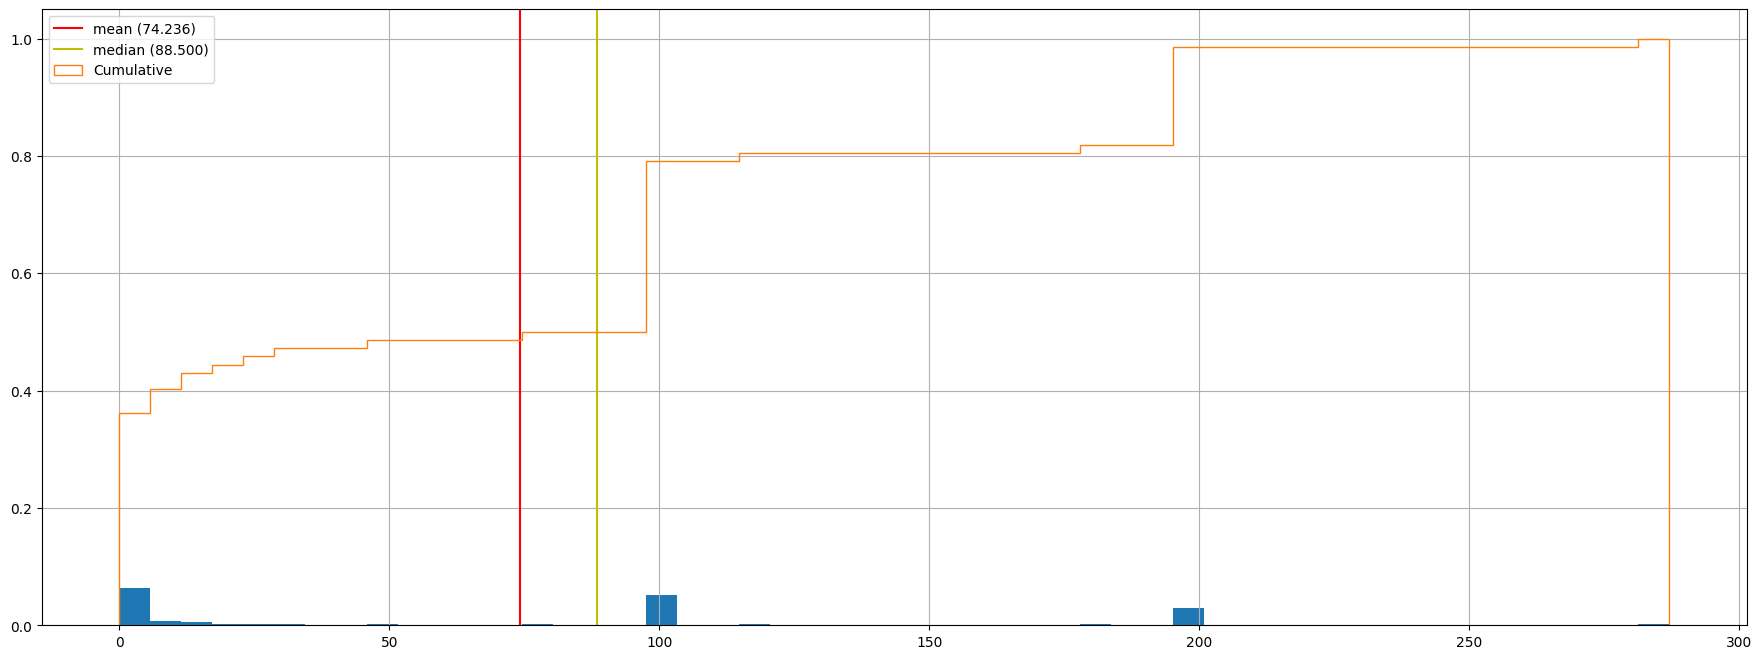

<Figure size 640x480 with 0 Axes>

In [49]:
plot_histogram(sizes, add_cumulative=True)

In [ ]:
CIFAR-10 1st_look_hardness 10.0 10.0 0
CIFAR-10 1st_look_hardness 25.0 10.0 20
CIFAR-10 1st_look_hardness 40.0 10.0 0

CIFAR-10 example_forgetting 10.0 3.0 0
CIFAR-10 example_forgetting 10.0 5.0 0
CIFAR-10 example_forgetting 10.0 2.0 0
CIFAR-10 example_forgetting 10.0 10.0 0

CIFAR-10 example_forgetting 25.0 10.0 0

CIFAR-10 example_forgetting 40.0 5.0 0
CIFAR-10 example_forgetting 40.0 10.0 0


MNIST-LeNet1 1st_look_hardness 25.0 5.0 0
MNIST-LeNet1 1st_look_hardness 25.0 2.0 14

MNIST-LeNet1 1st_look_hardness 40.0 5.0 0
MNIST-LeNet1 1st_look_hardness 40.0 2.0 0

MNIST-LeNet1 example_forgetting 10.0 3.0 10
MNIST-LeNet1 example_forgetting 10.0 5.0 47
MNIST-LeNet1 example_forgetting 10.0 2.0 3
MNIST-LeNet1 example_forgetting 10.0 10.0 4

MNIST-LeNet1 example_forgetting 25.0 3.0 6
MNIST-LeNet1 example_forgetting 25.0 2.0 12
MNIST-LeNet1 example_forgetting 25.0 10.0 32

MNIST-LeNet1 example_forgetting 40.0 3.0 23
MNIST-LeNet1 example_forgetting 40.0 5.0 3
MNIST-LeNet1 example_forgetting 40.0 2.0 9
MNIST-LeNet1 example_forgetting 40.0 10.0 77


MNIST-LeNet2 1st_look_hardness 10.0 5.0 1
MNIST-LeNet2 1st_look_hardness 10.0 2.0 0
MNIST-LeNet2 1st_look_hardness 10.0 10.0 0

MNIST-LeNet2 1st_look_hardness 40.0 3.0 0
MNIST-LeNet2 1st_look_hardness 40.0 5.0 0
MNIST-LeNet2 1st_look_hardness 40.0 2.0 0

MNIST-LeNet2 example_forgetting 10.0 2.0 0
MNIST-LeNet2 example_forgetting 10.0 10.0 0
MNIST-LeNet2 example_forgetting 25.0 2.0 0
MNIST-LeNet2 example_forgetting 25.0 10.0 0
MNIST-LeNet2 example_forgetting 40.0 10.0 0

In [351]:
fit_res_df = full_res_df.loc[full_res_df['test_acc'] > 0.011]
fit_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.011556,0.011197,3.0,32,64,112.0,80.0,472,elu,BatchNorm,1.0000,0.6863,151.0,45000.0,CIFAR-10,0,0,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001154,0.905991,2.0,24,64,120.0,80.0,480,elu,Dropout,0.1894,0.1912,16.0,45000.0,CIFAR-10,0,2,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005881,0.526295,2.0,16,40,80.0,112.0,968,tanh,BatchNorm,0.8038,0.6661,121.0,45000.0,CIFAR-10,0,3,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.137176,0.341528,3.0,24,56,72.0,104.0,456,tanh,BatchNorm,1.0000,0.7291,85.0,45000.0,CIFAR-10,0,4,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.376618,0.571824,3.0,16,56,72.0,72.0,208,tanh,BatchNorm,0.5852,0.5310,34.0,39542.0,CIFAR-10,0,5,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.043269,NaN,NaN,256,184,NaN,NaN,912,elu,NaN,0.9982,0.9925,211.0,19061.0,MNIST-LeNet2,148,82,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.695868,NaN,NaN,0.873554,NaN,NaN,NaN,Adam,1.0,NaN
83,0.000104,NaN,NaN,184,152,NaN,NaN,224,relu,NaN,0.9388,0.9387,157.0,19061.0,MNIST-LeNet2,148,83,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.609928,NaN,NaN,0.346549,NaN,NaN,NaN,AdaGrad,1.0,NaN
84,0.000309,NaN,NaN,112,112,NaN,NaN,208,elu,NaN,0.9652,0.9625,131.0,19061.0,MNIST-LeNet2,148,84,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.841333,NaN,NaN,0.556698,NaN,NaN,NaN,AdaGrad,1.0,NaN
85,0.001077,NaN,NaN,296,144,NaN,NaN,912,lrelu,NaN,0.9896,0.9839,253.0,19061.0,MNIST-LeNet2,148,85,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.803463,NaN,NaN,0.719261,NaN,NaN,NaN,AdaGrad,1.0,NaN


In [352]:
# full_res_df.loc[full_res_df['test_acc'] <= 0.1012]

In [353]:
fit_res_df.corr()

<ipython-input-353-01e92ac64854>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  fit_res_df.corr()


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,val_acc,test_acc,time_spent,train_set_size,exp_index,run_idx,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,batch_normalization,50
learning_rate,1.000000,0.031138,-0.143555,-0.125019,-0.101570,-0.007643,0.046855,-0.020711,-0.197596,-0.214059,0.019711,0.183620,-0.192979,-0.079618,0.099753,-0.097747,0.025606,-0.000231,-0.078889,0.011690,0.039729,-0.053353,0.042018,NaN,NaN,NaN,0.126838,NaN
l2_reg,0.031138,1.000000,0.024234,-0.029267,0.011924,-0.027909,-0.026329,0.063585,-0.038245,-0.046682,-0.013336,-0.009199,0.009097,0.016159,-0.057319,-0.001735,0.028898,0.080050,0.032881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
window_size,-0.143555,0.024234,1.000000,0.485302,0.408050,-0.038289,-0.005873,-0.066267,0.085178,0.238409,-0.223896,-0.446178,0.601198,-0.019940,-0.057954,0.443214,0.162788,0.142894,0.027725,0.030656,0.079163,-0.068364,0.114898,NaN,NaN,NaN,NaN,NaN
conv1_depth,-0.125019,-0.029267,0.485302,1.000000,0.446216,-0.002080,0.042064,0.134303,0.081586,0.230242,-0.183435,-0.466010,0.529807,-0.028347,0.049055,0.408336,0.261210,0.154874,0.099575,0.009163,0.077460,0.122032,-0.094104,NaN,NaN,NaN,-0.002384,NaN
conv2_depth,-0.101570,0.011924,0.408050,0.446216,1.000000,0.053152,-0.051787,0.113096,0.090518,0.226493,-0.234153,-0.501998,0.555278,0.062953,0.079406,0.339245,0.055634,0.203317,0.130660,-0.055154,0.046939,0.043808,-0.048975,NaN,NaN,NaN,0.005782,NaN
conv3_depth,-0.007643,-0.027909,-0.038289,-0.002080,0.053152,1.000000,0.053177,0.068403,0.013604,0.004762,0.057509,0.065962,-0.056322,0.012983,0.038193,-0.000384,-0.007541,-0.080331,-0.047557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conv4_depth,0.046855,-0.026329,-0.005873,0.042064,-0.051787,0.053177,1.000000,-0.033129,-0.029713,-0.033364,0.063368,0.034860,0.024826,0.053408,0.082124,0.018963,-0.067528,-0.103654,-0.067651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fc_depth,-0.020711,0.063585,-0.066267,0.134303,0.113096,0.068403,-0.033129,1.000000,0.011174,0.036097,0.093001,-0.069170,0.037012,0.041863,-0.023679,-0.031854,0.035501,0.099239,0.020510,0.030807,0.051837,-0.016593,-0.083736,NaN,NaN,NaN,0.016015,NaN
val_acc,-0.197596,-0.038245,0.085178,0.081586,0.090518,0.013604,-0.029713,0.011174,1.000000,0.939686,0.208766,0.055792,0.129130,-0.018009,-0.039019,-0.186344,-0.045554,0.028139,0.050946,0.023050,-0.005096,0.008297,0.072531,NaN,NaN,NaN,0.090426,NaN
test_acc,-0.214059,-0.046682,0.238409,0.230242,0.226493,0.004762,-0.033364,0.036097,0.939686,1.000000,0.078307,-0.094423,0.302231,-0.006641,-0.001163,-0.109358,-0.022497,0.101583,0.049890,0.023627,-0.005564,0.008787,0.071211,NaN,NaN,NaN,0.087208,NaN


In [39]:
plot_scatter_historgram(full_res_df['train_set_size'], full_res_df['test_acc'])

ValueError: autodetected range of [nan, nan] is not finite

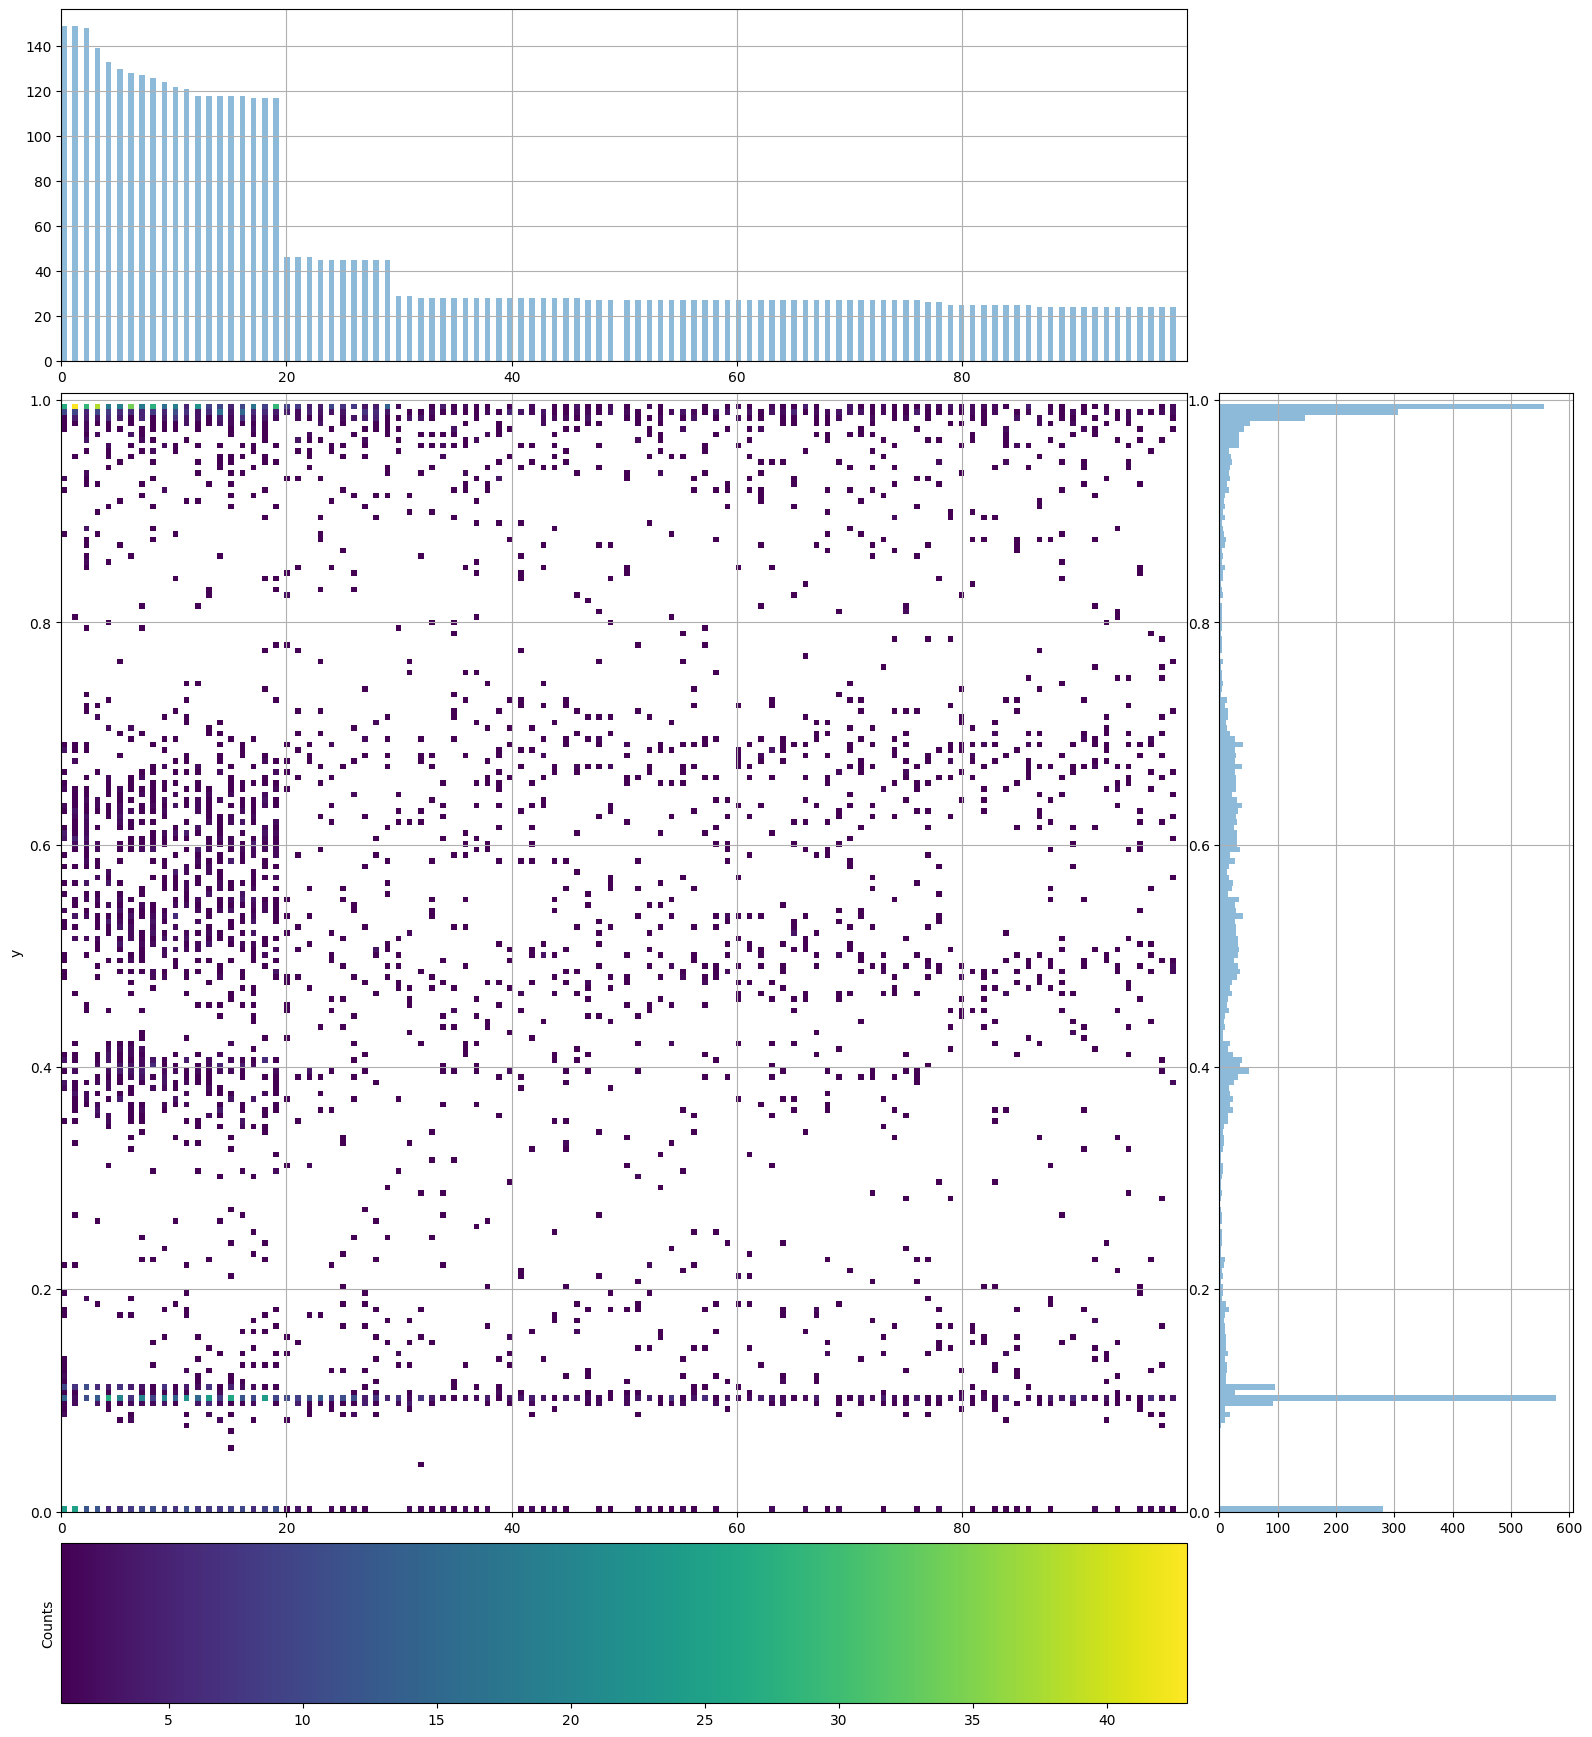

<Figure size 640x480 with 0 Axes>

In [40]:
plot_scatter_historgram(full_res_df['run_idx'], full_res_df['test_acc'])

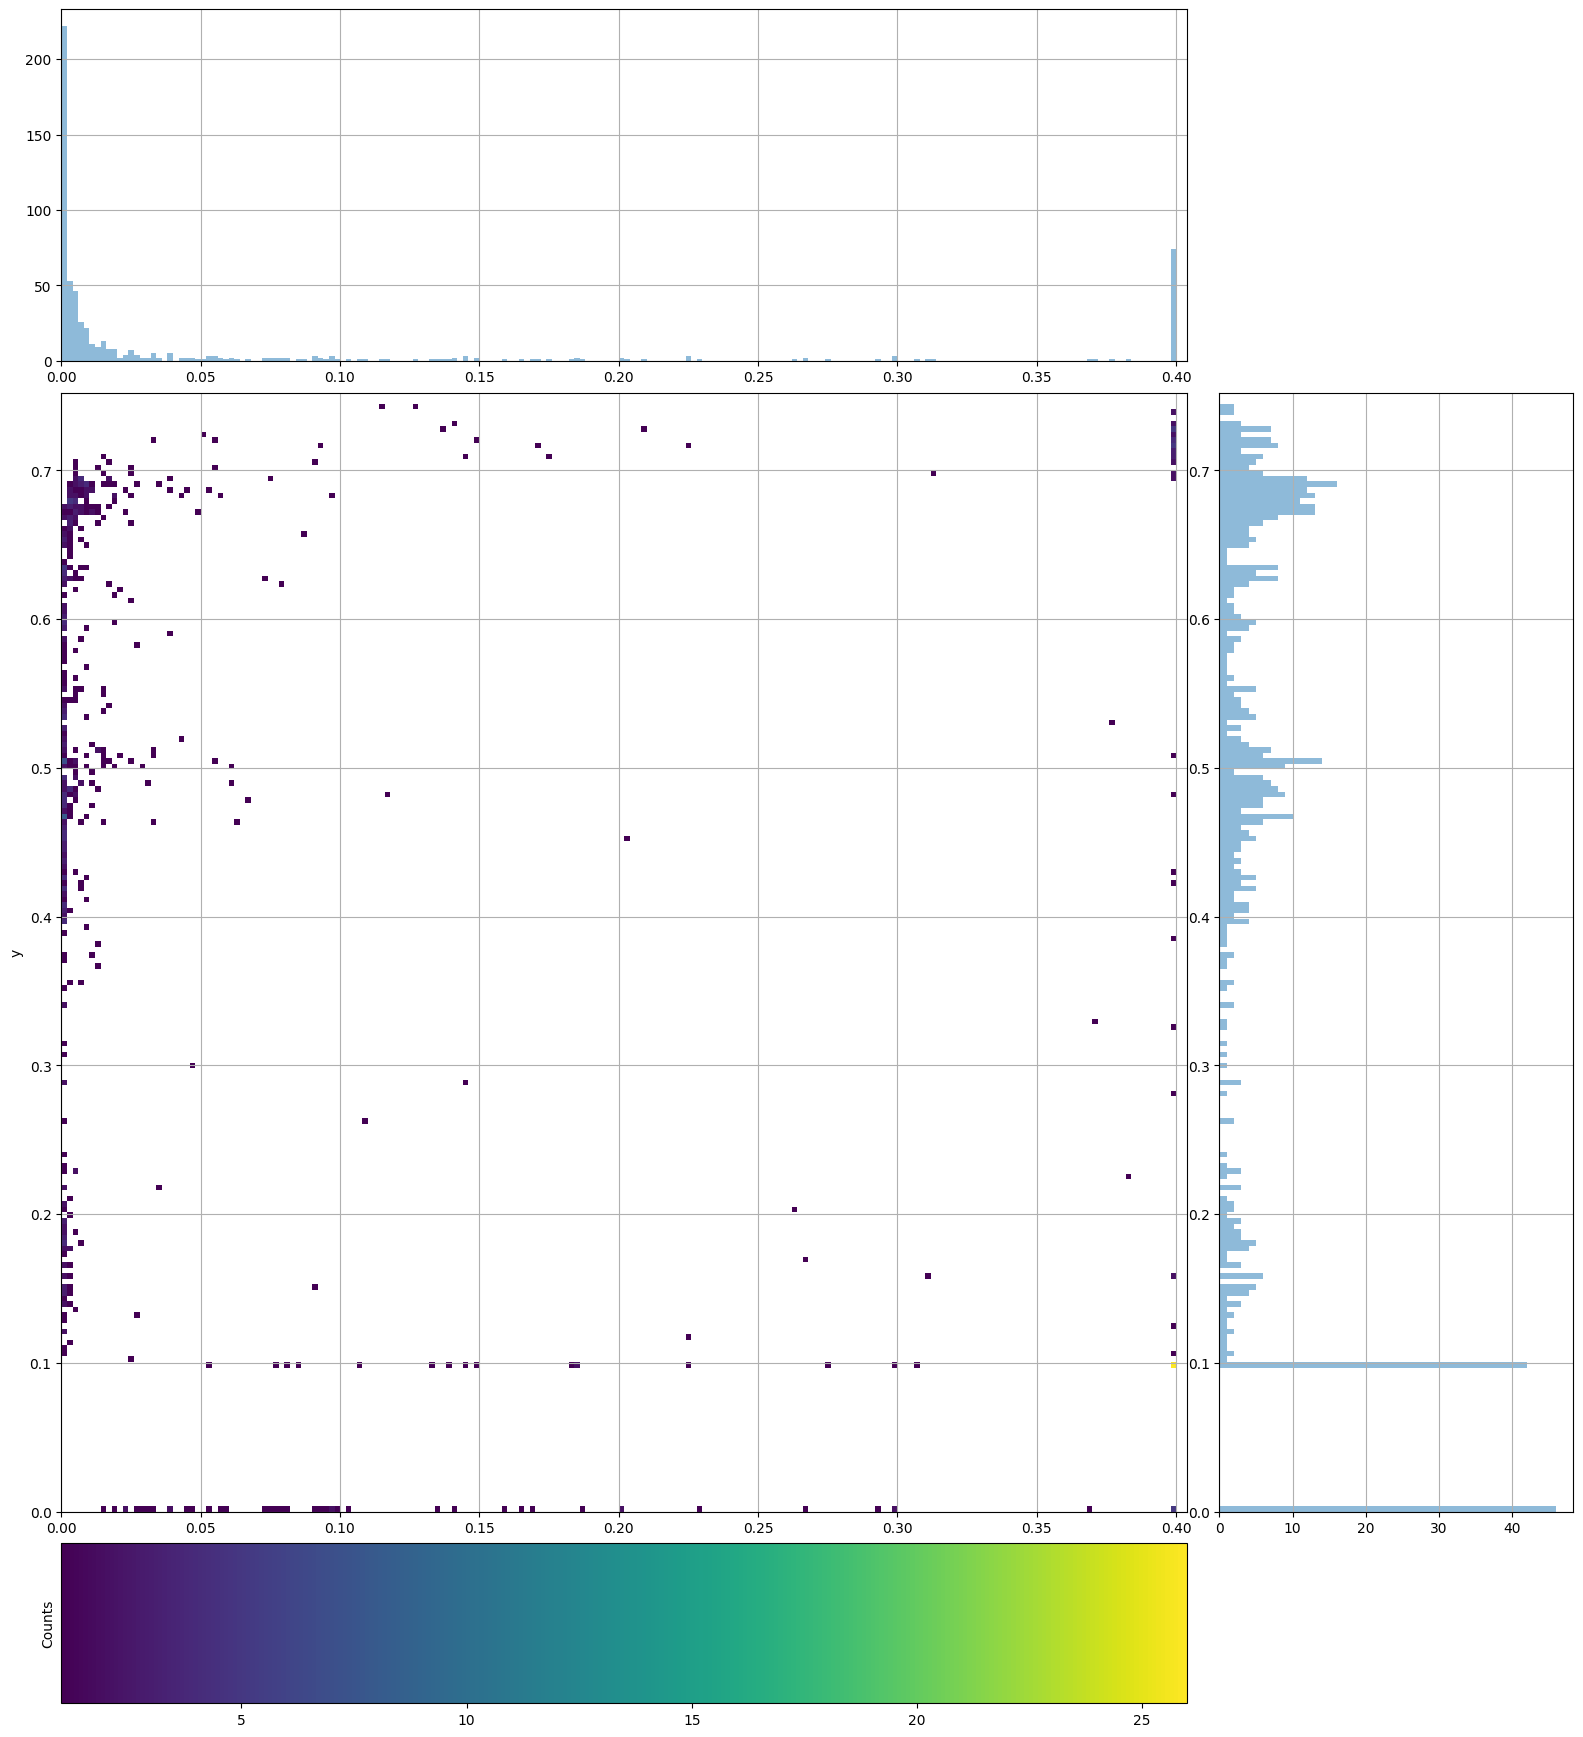

<Figure size 640x480 with 0 Axes>

In [311]:
plot_scatter_historgram(full_res_df['learning_rate'], full_res_df['test_acc'])

In [354]:
full_res_df.loc[full_res_df['train_set_size'] == 0]

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
3,0.000167,0.097403,2.0,24,64,96.0,128.0,928,tanh,None,0.0942,0.1002,42.0,0.0,CIFAR-10,58,3,example_forgetting,ucb,25.0,NaN,1,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.001860,0.000872,2.0,24,48,96.0,88.0,856,elu,Dropout,0.0954,0.0910,22.0,0.0,CIFAR-10,58,4,example_forgetting,ucb,25.0,NaN,1,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.014702,0.963886,3.0,32,32,80.0,72.0,760,elu,BatchNorm,0.0806,0.0835,14.0,0.0,CIFAR-10,58,5,example_forgetting,ucb,25.0,NaN,1,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.000140,0.341959,3.0,8,56,96.0,96.0,32,relu,None,0.0834,0.0813,4.0,0.0,CIFAR-10,58,6,example_forgetting,ucb,25.0,NaN,1,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.000607,0.411253,2.0,16,40,104.0,120.0,344,relu,Dropout,0.0960,0.1009,18.0,0.0,CIFAR-10,58,7,example_forgetting,ucb,25.0,NaN,1,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.020067,0.673930,3.0,8,56,112.0,88.0,80,tanh,BatchNorm,0.1086,0.1060,6.0,0.0,CIFAR-10,58,8,example_forgetting,ucb,25.0,NaN,1,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.000973,0.452633,3.0,32,40,72.0,112.0,528,elu,None,0.1070,0.1046,8.0,0.0,CIFAR-10,58,9,example_forgetting,ucb,25.0,NaN,1,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.005199,0.215228,3.0,24,56,88.0,104.0,192,elu,Dropout,0.1062,0.1066,7.0,0.0,CIFAR-10,58,10,example_forgetting,ucb,25.0,NaN,1,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.000607,0.787657,3.0,16,32,72.0,72.0,424,relu,None,0.0792,0.0771,10.0,0.0,CIFAR-10,58,11,example_forgetting,ucb,25.0,NaN,1,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.000142,0.241169,3.0,16,64,88.0,80.0,632,tanh,BatchNorm,0.1048,0.1002,8.0,0.0,CIFAR-10,58,12,example_forgetting,ucb,25.0,NaN,1,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Depreciated, use calculate_CED
k=10.0 | size: 946 | test_acc: 0.5269
Depreciated, use calculate_CED
k=25.0 | size: 1597 | test_acc: 0.5131
Depreciated, use calculate_CED
k=40.0 | size: 1599 | test_acc: 0.5457


{10.0: 0.5269480972515856, 25.0: 0.5131367564182843, 40.0: 0.545733583489681}

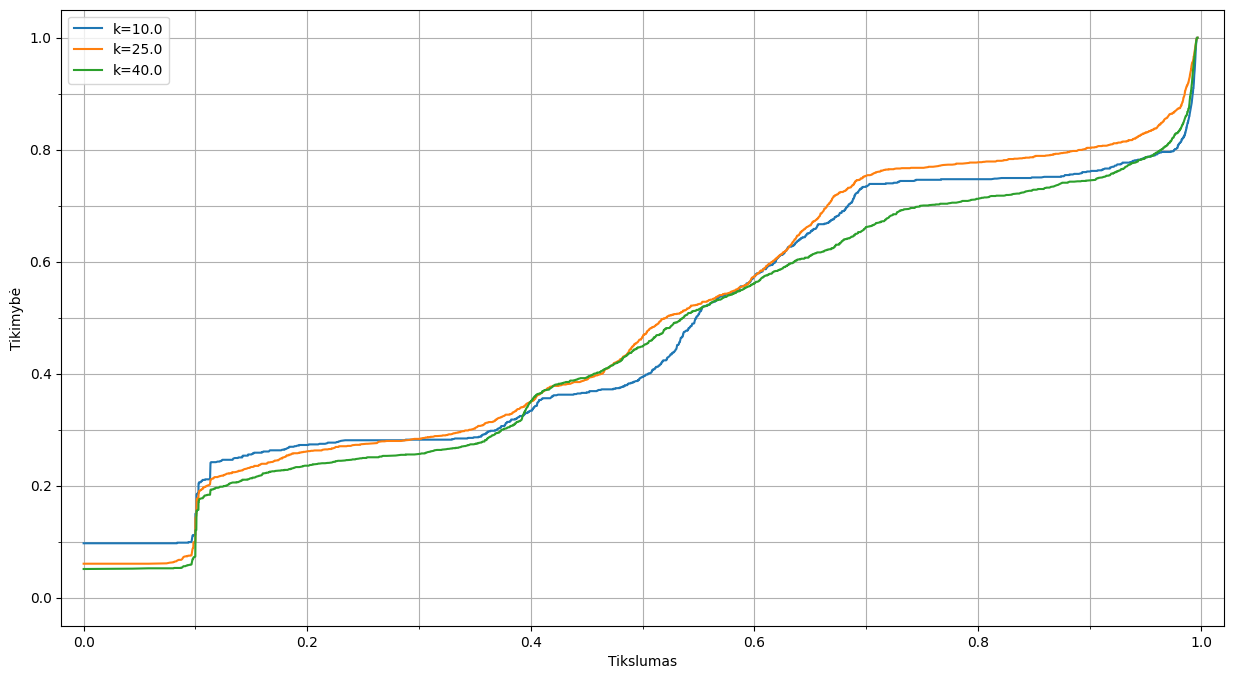

In [355]:
categorical_metric_analysis(full_res_df, ['k'], 'test_acc', True, False, (15, 8))

In [ ]:
categorical_metric_analysis(full_res_df, ['ftk'], 'test_acc', True, False)

Depreciated, use calculate_CED
run_idx=0 | size: 149 | test_acc: 0.4746
Depreciated, use calculate_CED
run_idx=1 | size: 149 | test_acc: 0.5892
Depreciated, use calculate_CED
run_idx=2 | size: 148 | test_acc: 0.6131
Depreciated, use calculate_CED
run_idx=3 | size: 139 | test_acc: 0.5957
Depreciated, use calculate_CED
run_idx=4 | size: 133 | test_acc: 0.5247
Depreciated, use calculate_CED
run_idx=5 | size: 130 | test_acc: 0.5152
Depreciated, use calculate_CED
run_idx=6 | size: 128 | test_acc: 0.5952
Depreciated, use calculate_CED
run_idx=7 | size: 127 | test_acc: 0.5107
Depreciated, use calculate_CED
run_idx=8 | size: 126 | test_acc: 0.5971
Depreciated, use calculate_CED
run_idx=9 | size: 124 | test_acc: 0.4887
Depreciated, use calculate_CED
run_idx=10 | size: 122 | test_acc: 0.5937
Depreciated, use calculate_CED
run_idx=11 | size: 121 | test_acc: 0.4366
Depreciated, use calculate_CED
run_idx=12 | size: 118 | test_acc: 0.5472
Depreciated, use calculate_CED
run_idx=13 | size: 118 | test_

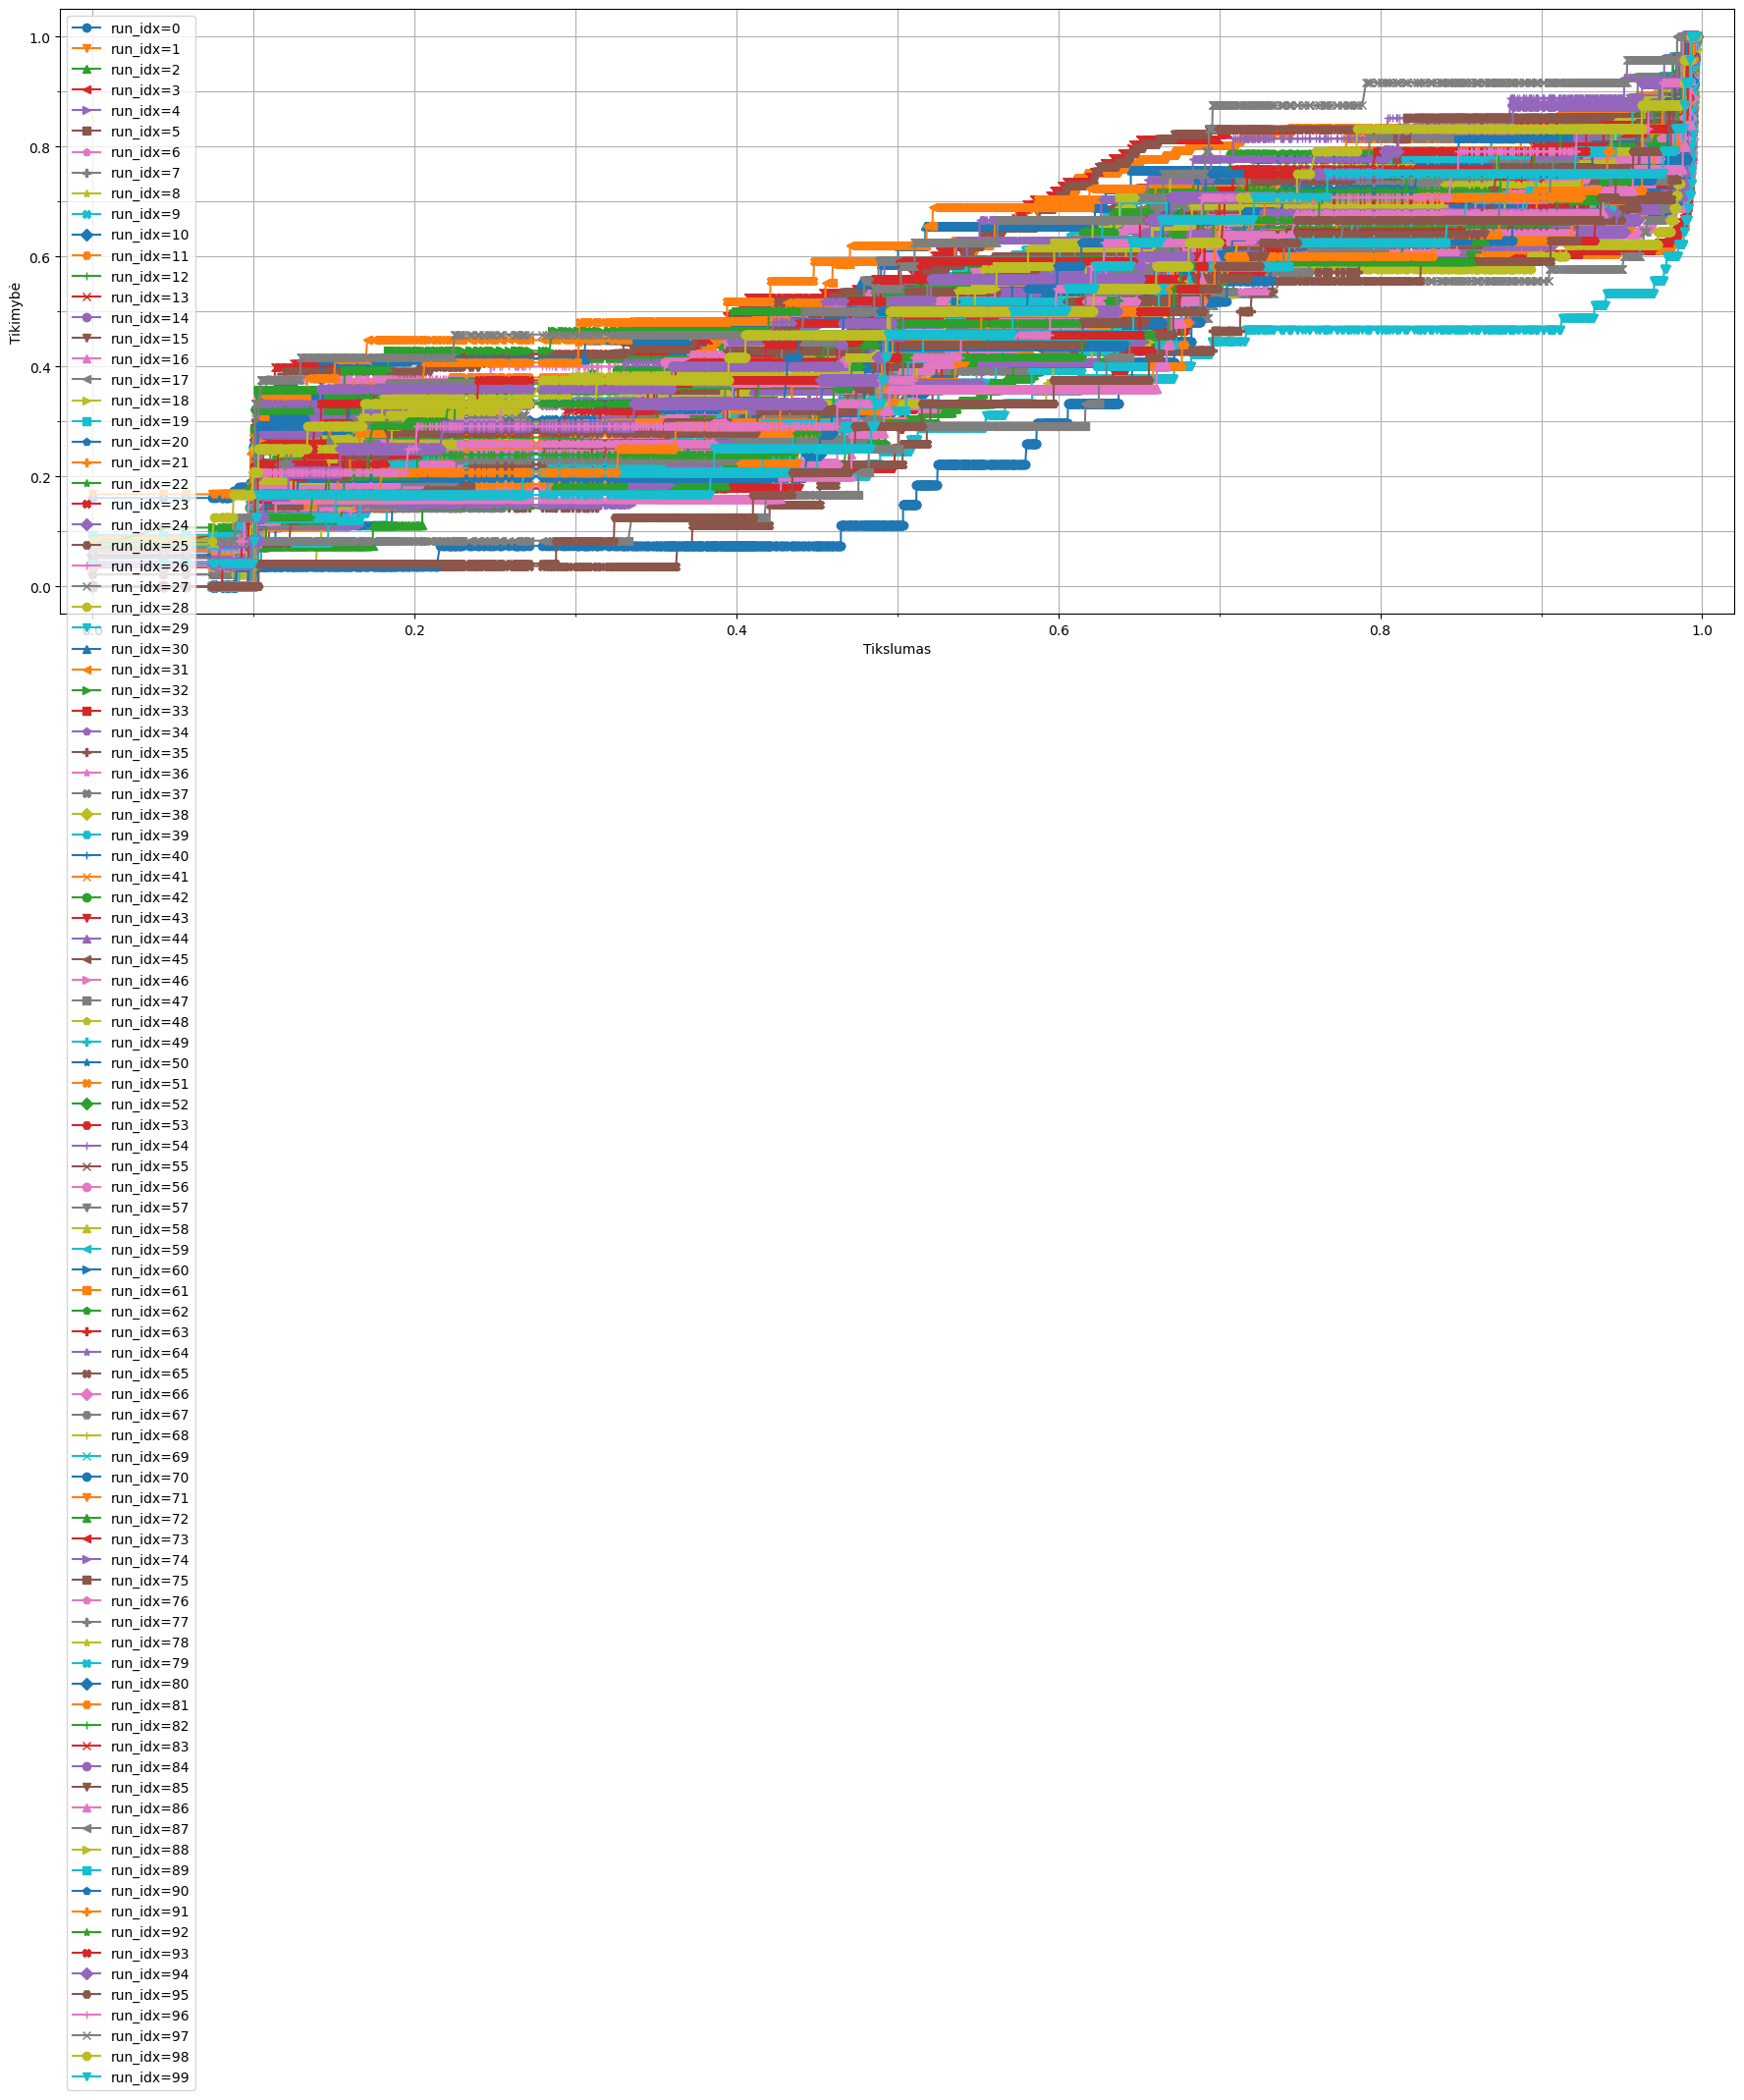

In [357]:
categorical_accuracies = categorical_metric_analysis(full_res_df, ['run_idx'], 'test_acc', True)

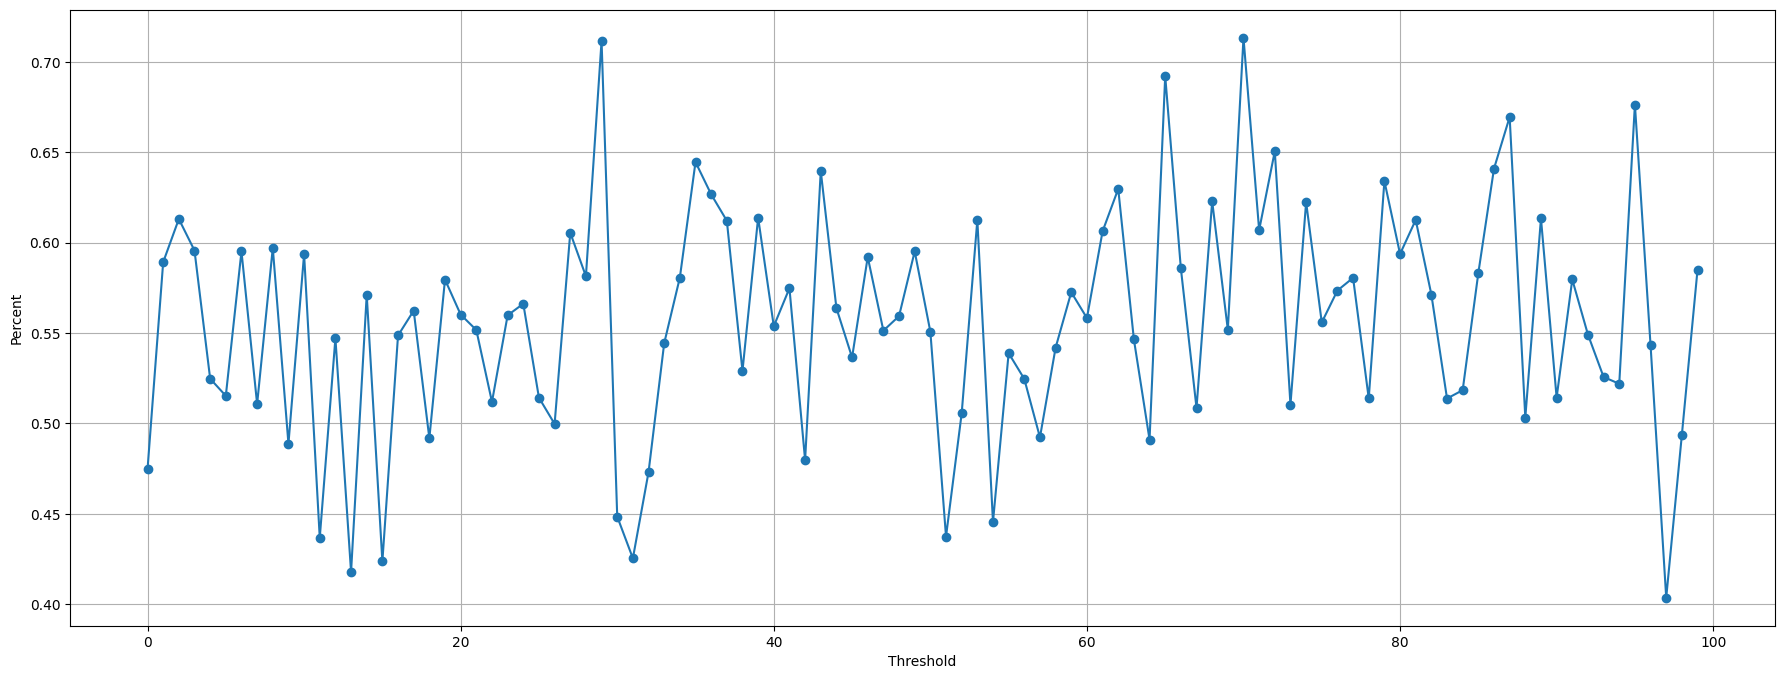

<Figure size 640x480 with 0 Axes>

In [358]:
plot_xy_curves(list(categorical_accuracies.keys()), [list(categorical_accuracies.values())])

In [359]:
fit_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.011556,0.011197,3.0,32,64,112.0,80.0,472,elu,BatchNorm,1.0000,0.6863,151.0,45000.0,CIFAR-10,0,0,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001154,0.905991,2.0,24,64,120.0,80.0,480,elu,Dropout,0.1894,0.1912,16.0,45000.0,CIFAR-10,0,2,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005881,0.526295,2.0,16,40,80.0,112.0,968,tanh,BatchNorm,0.8038,0.6661,121.0,45000.0,CIFAR-10,0,3,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.137176,0.341528,3.0,24,56,72.0,104.0,456,tanh,BatchNorm,1.0000,0.7291,85.0,45000.0,CIFAR-10,0,4,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.376618,0.571824,3.0,16,56,72.0,72.0,208,tanh,BatchNorm,0.5852,0.5310,34.0,39542.0,CIFAR-10,0,5,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.043269,NaN,NaN,256,184,NaN,NaN,912,elu,NaN,0.9982,0.9925,211.0,19061.0,MNIST-LeNet2,148,82,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.695868,NaN,NaN,0.873554,NaN,NaN,NaN,Adam,1.0,NaN
83,0.000104,NaN,NaN,184,152,NaN,NaN,224,relu,NaN,0.9388,0.9387,157.0,19061.0,MNIST-LeNet2,148,83,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.609928,NaN,NaN,0.346549,NaN,NaN,NaN,AdaGrad,1.0,NaN
84,0.000309,NaN,NaN,112,112,NaN,NaN,208,elu,NaN,0.9652,0.9625,131.0,19061.0,MNIST-LeNet2,148,84,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.841333,NaN,NaN,0.556698,NaN,NaN,NaN,AdaGrad,1.0,NaN
85,0.001077,NaN,NaN,296,144,NaN,NaN,912,lrelu,NaN,0.9896,0.9839,253.0,19061.0,MNIST-LeNet2,148,85,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.803463,NaN,NaN,0.719261,NaN,NaN,NaN,AdaGrad,1.0,NaN


In [360]:
fit_res_df.sort_values('test_acc', ascending=False).head(3)['test_acc'].index.to_list()

[6, 26, 28]

### Check for duplicated architectures

In [362]:
float_columns = ['learning_rate', 'l2_reg']

rounded_full_res_df = full_res_df.copy()  # full_res_df.drop(columns=full_res_df.columns[10:])
rounded_full_res_df['learning_rate'] = np.round(rounded_full_res_df['learning_rate'], 3)
# rounded_full_res_df['l2_reg'] = np.round(rounded_full_res_df['l2_reg'], 2)
rounded_full_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.012,0.011197,3.0,32,64,112.0,80.0,472,elu,BatchNorm,1.0000,0.6863,151.0,45000.0,CIFAR-10,0,0,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.076,0.526661,3.0,32,64,112.0,80.0,256,elu,None,0.0000,0.0000,0.0,45000.0,CIFAR-10,0,1,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001,0.905991,2.0,24,64,120.0,80.0,480,elu,Dropout,0.1894,0.1912,16.0,45000.0,CIFAR-10,0,2,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.006,0.526295,2.0,16,40,80.0,112.0,968,tanh,BatchNorm,0.8038,0.6661,121.0,45000.0,CIFAR-10,0,3,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.137,0.341528,3.0,24,56,72.0,104.0,456,tanh,BatchNorm,1.0000,0.7291,85.0,45000.0,CIFAR-10,0,4,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.043,NaN,NaN,256,184,NaN,NaN,912,elu,NaN,0.9982,0.9925,211.0,19061.0,MNIST-LeNet2,148,82,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.695868,NaN,NaN,0.873554,NaN,NaN,NaN,Adam,1.0,NaN
83,0.000,NaN,NaN,184,152,NaN,NaN,224,relu,NaN,0.9388,0.9387,157.0,19061.0,MNIST-LeNet2,148,83,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.609928,NaN,NaN,0.346549,NaN,NaN,NaN,AdaGrad,1.0,NaN
84,0.000,NaN,NaN,112,112,NaN,NaN,208,elu,NaN,0.9652,0.9625,131.0,19061.0,MNIST-LeNet2,148,84,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.841333,NaN,NaN,0.556698,NaN,NaN,NaN,AdaGrad,1.0,NaN
85,0.001,NaN,NaN,296,144,NaN,NaN,912,lrelu,NaN,0.9896,0.9839,253.0,19061.0,MNIST-LeNet2,148,85,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.803463,NaN,NaN,0.719261,NaN,NaN,NaN,AdaGrad,1.0,NaN


In [363]:
categorical_accuracies = categorical_metric_analysis(rounded_full_res_df, ['learning_rate'], 'test_acc', True)

Depreciated, use calculate_CED
learning_rate=0.0 | size: 1462 | test_acc: 0.6480
Depreciated, use calculate_CED
learning_rate=0.001 | size: 661 | test_acc: 0.7050
Depreciated, use calculate_CED
learning_rate=0.002 | size: 286 | test_acc: 0.6810
Depreciated, use calculate_CED
learning_rate=0.003 | size: 213 | test_acc: 0.6229
Depreciated, use calculate_CED
learning_rate=0.004 | size: 163 | test_acc: 0.6035
Depreciated, use calculate_CED
learning_rate=0.005 | size: 106 | test_acc: 0.5458
Depreciated, use calculate_CED
learning_rate=0.006 | size: 85 | test_acc: 0.5533
Depreciated, use calculate_CED
learning_rate=0.007 | size: 76 | test_acc: 0.5785
Depreciated, use calculate_CED
learning_rate=0.008 | size: 59 | test_acc: 0.5013
Depreciated, use calculate_CED
learning_rate=0.009 | size: 50 | test_acc: 0.5113
Depreciated, use calculate_CED
learning_rate=0.01 | size: 61 | test_acc: 0.4876
Depreciated, use calculate_CED
learning_rate=0.011 | size: 44 | test_acc: 0.4860
Depreciated, use calcula

learning_rate=0.101 | size:  2 | test_acc: 0.7508
Depreciated, use calculate_CED
learning_rate=0.102 | size:  3 | test_acc: 0.1006
Depreciated, use calculate_CED
learning_rate=0.103 | size:  5 | test_acc: 0.1984
Depreciated, use calculate_CED
learning_rate=0.104 | size:  1 | test_acc: 0.0000
Depreciated, use calculate_CED
learning_rate=0.105 | size:  2 | test_acc: 0.2044
Depreciated, use calculate_CED
learning_rate=0.106 | size:  3 | test_acc: 0.1012
Depreciated, use calculate_CED
learning_rate=0.107 | size:  3 | test_acc: 0.3982
Depreciated, use calculate_CED
learning_rate=0.108 | size:  2 | test_acc: 0.1812
Depreciated, use calculate_CED
learning_rate=0.109 | size:  3 | test_acc: 0.0333
Depreciated, use calculate_CED
learning_rate=0.111 | size:  1 | test_acc: 0.0000
Depreciated, use calculate_CED
learning_rate=0.113 | size:  2 | test_acc: 0.2628
Depreciated, use calculate_CED
learning_rate=0.114 | size:  2 | test_acc: 0.0995
Depreciated, use calculate_CED
learning_rate=0.115 | size: 

KeyboardInterrupt: 

In [323]:
2 * ((32-8) / 8) * ((64-32) / 8) * ((128-64) / 8) * ((128-64) / 8) * ((1024-8) / 8) * 3 * 3

1755648.0

### Experiment based graphs

In [474]:
good_res_df = full_res_df.loc[full_res_df['k'].isin([10, 25, 40])]
good_res_df['k'] = good_res_df['k'] / 10
good_res_df

<ipython-input-474-7c530254c0ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_res_df['k'] = good_res_df['k'] / 10


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,root,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.011556,0.011197,3.0,32,64,112.0,80.0,472,elu,BatchNorm,1.0000,0.6863,151.0,45000.0,CIFAR-10,0,0,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,1.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.076464,0.526661,3.0,32,64,112.0,80.0,256,elu,None,0.0000,0.0000,0.0,45000.0,CIFAR-10,0,1,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,1.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001154,0.905991,2.0,24,64,120.0,80.0,480,elu,Dropout,0.1894,0.1912,16.0,45000.0,CIFAR-10,0,2,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,1.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005881,0.526295,2.0,16,40,80.0,112.0,968,tanh,BatchNorm,0.8038,0.6661,121.0,45000.0,CIFAR-10,0,3,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,1.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.137176,0.341528,3.0,24,56,72.0,104.0,456,tanh,BatchNorm,1.0000,0.7291,85.0,45000.0,CIFAR-10,0,4,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,1.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.043269,NaN,NaN,256,184,NaN,NaN,912,elu,NaN,0.9982,0.9925,211.0,19061.0,MNIST-LeNet2,148,82,\MNIST-LeNet2\LeNet2-05-16\1st_look_hardness-u...,1st_look_hardness,ucb,2.5,3.0,1,NaN,NaN,0.695868,NaN,NaN,0.873554,NaN,NaN,NaN,Adam,1.0,NaN
83,0.000104,NaN,NaN,184,152,NaN,NaN,224,relu,NaN,0.9388,0.9387,157.0,19061.0,MNIST-LeNet2,148,83,\MNIST-LeNet2\LeNet2-05-16\1st_look_hardness-u...,1st_look_hardness,ucb,2.5,3.0,1,NaN,NaN,0.609928,NaN,NaN,0.346549,NaN,NaN,NaN,AdaGrad,1.0,NaN
84,0.000309,NaN,NaN,112,112,NaN,NaN,208,elu,NaN,0.9652,0.9625,131.0,19061.0,MNIST-LeNet2,148,84,\MNIST-LeNet2\LeNet2-05-16\1st_look_hardness-u...,1st_look_hardness,ucb,2.5,3.0,1,NaN,NaN,0.841333,NaN,NaN,0.556698,NaN,NaN,NaN,AdaGrad,1.0,NaN
85,0.001077,NaN,NaN,296,144,NaN,NaN,912,lrelu,NaN,0.9896,0.9839,253.0,19061.0,MNIST-LeNet2,148,85,\MNIST-LeNet2\LeNet2-05-16\1st_look_hardness-u...,1st_look_hardness,ucb,2.5,3.0,1,NaN,NaN,0.803463,NaN,NaN,0.719261,NaN,NaN,NaN,AdaGrad,1.0,NaN


In [475]:
# good_res_df = good_res_df.loc[good_res_df['filter_method'] == '1st_look_hardness']
# good_res_df

In [476]:
lenet1_res_df = good_res_df.loc[good_res_df['experiment_type'] == 'MNIST-LeNet1']
lenet2_res_df = good_res_df.loc[good_res_df['experiment_type'] == 'MNIST-LeNet2']
lenet3_res_df = good_res_df.loc[good_res_df['experiment_type'] == 'CIFAR-10']

no_lenet2_res_df = good_res_df.loc[good_res_df['experiment_type'] != 'MNIST-LeNet2']
mnist_res_df = good_res_df.loc[good_res_df['experiment_type'] != 'CIFAR-10']

lenet1_res_df.shape, lenet2_res_df.shape, lenet3_res_df.shape, no_lenet2_res_df.shape, mnist_res_df.shape

((1181, 35), (587, 35), (2374, 35), (3555, 35), (1768, 35))

MNIST-LeNet1
Depreciated, use calculate_CED
k=1.0 | size: 374 | test_acc: 0.6690
Depreciated, use calculate_CED
k=2.5 | size: 413 | test_acc: 0.6644
Depreciated, use calculate_CED
k=4.0 | size: 394 | test_acc: 0.6578
MNIST-LeNet2
Depreciated, use calculate_CED
k=2.5 | size: 187 | test_acc: 0.6688
Depreciated, use calculate_CED
k=4.0 | size: 400 | test_acc: 0.6880
MNIST-LeNet1 and LeNet2
Depreciated, use calculate_CED
k=1.0 | size: 374 | test_acc: 0.6690
Depreciated, use calculate_CED
k=2.5 | size: 600 | test_acc: 0.6658
Depreciated, use calculate_CED
k=4.0 | size: 794 | test_acc: 0.6730
CIFAR-10
Depreciated, use calculate_CED
k=1.0 | size: 572 | test_acc: 0.4341
Depreciated, use calculate_CED
k=2.5 | size: 997 | test_acc: 0.4213
Depreciated, use calculate_CED
k=4.0 | size: 805 | test_acc: 0.4202


{1.0: 0.4340519230769231, 2.5: 0.4212704112337011, 4.0: 0.4202145341614907}

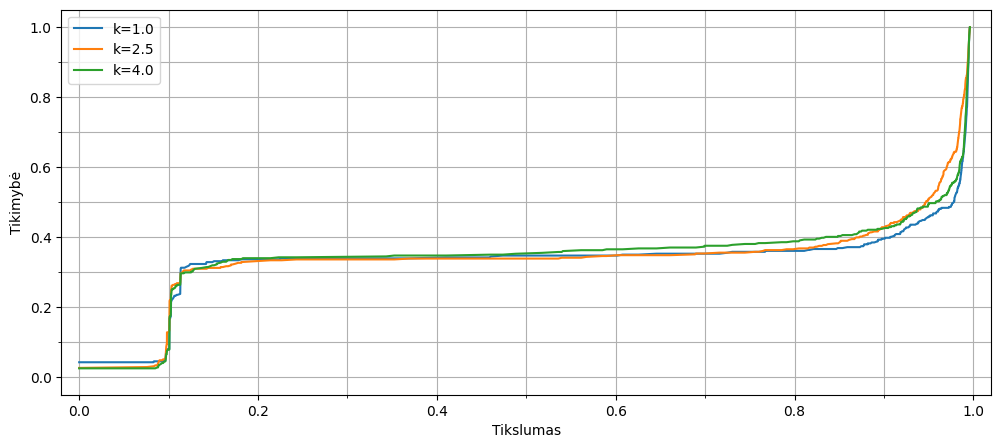

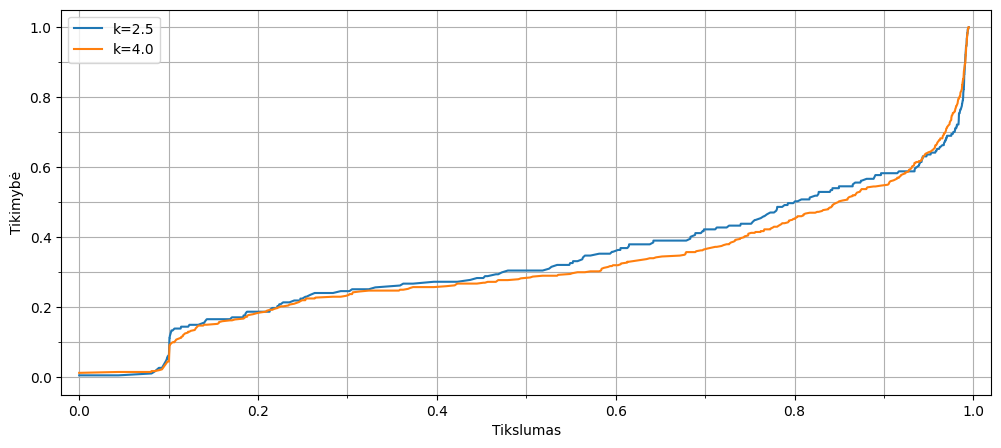

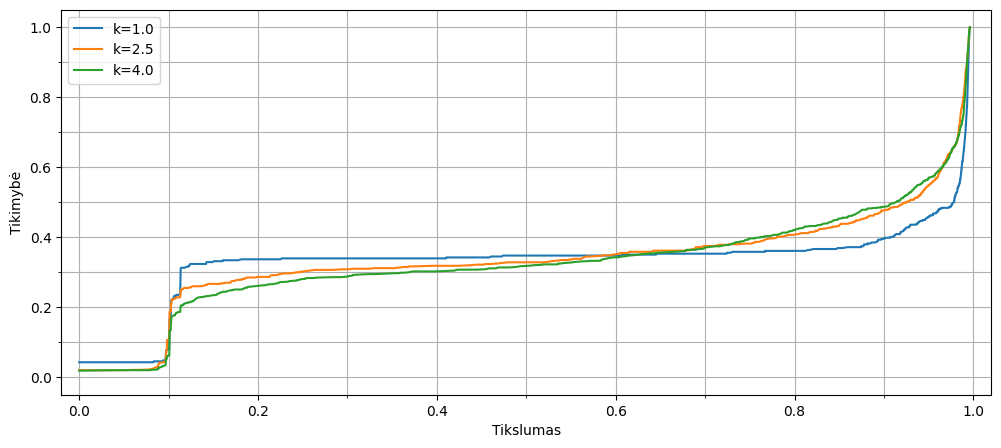

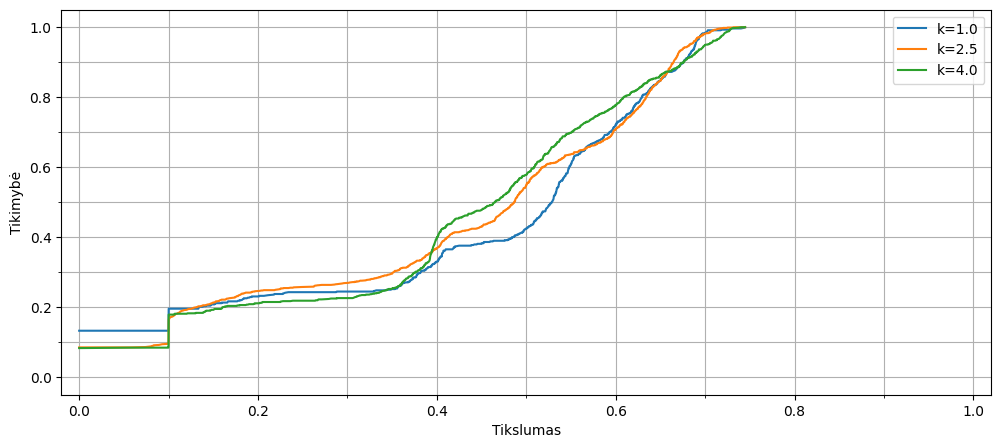

In [477]:
print('MNIST-LeNet1')
categorical_metric_analysis(lenet1_res_df, ['k'], 'test_acc', True, False, (12, 5))
print('MNIST-LeNet2')
categorical_metric_analysis(lenet2_res_df, ['k'], 'test_acc', True, False, (12, 5))
print('MNIST-LeNet1 and LeNet2')
categorical_metric_analysis(mnist_res_df, ['k'], 'test_acc', True, False, (12, 5))
print('CIFAR-10')
categorical_metric_analysis(lenet3_res_df, ['k'], 'test_acc', True, False, (12, 5))

In [478]:
display(lenet3_res_df.loc[lenet3_res_df['k'] == 1].sort_values('test_acc', ascending=False).head(2))
display(lenet3_res_df.loc[lenet3_res_df['k'] == 2.5].sort_values('test_acc', ascending=False).head(2))
display(lenet3_res_df.loc[lenet3_res_df['k'] == 4].sort_values('test_acc', ascending=False).head(2))

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,root,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
70,0.128011,0.737219,3.0,24,64,72.0,104.0,376,elu,BatchNorm,0.9966,0.7447,82.0,41038.0,CIFAR-10,0,70,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,1.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,0.115370,0.589419,3.0,24,48,96.0,88.0,360,elu,BatchNorm,0.9956,0.7435,73.0,41038.0,CIFAR-10,0,89,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,1.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,root,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
11,0.4000,1.000000,2.0,32,40,64.0,128.0,200,tanh,BatchNorm,0.9986,0.7317,108.0,44598.0,CIFAR-10,2,11,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,2.5,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0671,0.001766,3.0,24,48,64.0,72.0,456,relu,BatchNorm,1.0000,0.7252,218.0,45000.0,CIFAR-10,66,2,\CIFAR-10-LeNet\min_agreggation-fix\example_fo...,example_forgetting,ucb,2.5,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,root,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
87,0.4,1.0,3.0,32,64,112.0,128.0,104,tanh,BatchNorm,1.0,0.7401,121.0,44993.0,CIFAR-10,6,87,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,4.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,0.4,0.0,3.0,32,64,112.0,128.0,72,relu,BatchNorm,1.0,0.7379,143.0,44993.0,CIFAR-10,6,27,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,4.0,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train size vs acc

In [479]:
lenet3_res_df = lenet3_res_df.loc[lenet3_res_df['train_set_size'] > 300]

In [480]:
mnist_res_df.sort_values('train_set_size', ascending=False)

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,root,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.000520,NaN,3.0,208,336,NaN,NaN,576,NaN,NaN,0.9998,0.9943,178.0,55000.0,MNIST-LeNet1,96,0,\MNIST-LeNet1\1st_look_hardness-ucb-k10-ftk10,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.042754,3.0,2.0,0.393258,NaN,NaN,NaN,NaN,NaN,NaN
7,0.001506,NaN,6.0,296,232,NaN,NaN,24,NaN,NaN,1.0000,0.9942,263.0,55000.0,MNIST-LeNet1,119,7,\MNIST-LeNet1\frequency\example_forgetting-ucb...,example_forgetting,ucb,4.0,NaN,1,10.0,5.0,0.141661,2.0,2.0,0.879380,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000118,NaN,7.0,272,280,NaN,NaN,928,NaN,NaN,1.0000,0.9932,591.0,55000.0,MNIST-LeNet1,118,4,\MNIST-LeNet1\frequency\example_forgetting-ucb...,example_forgetting,ucb,2.5,NaN,2,5.0,7.0,0.590964,3.0,2.0,0.878706,NaN,NaN,NaN,NaN,NaN,NaN
0,0.000510,NaN,4.0,64,24,NaN,NaN,312,NaN,NaN,0.9708,0.9718,94.0,55000.0,MNIST-LeNet1,119,0,\MNIST-LeNet1\frequency\example_forgetting-ucb...,example_forgetting,ucb,4.0,NaN,1,10.0,5.0,0.793503,2.0,3.0,0.102230,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000146,NaN,7.0,224,248,NaN,NaN,552,NaN,NaN,0.9972,0.9954,1024.0,55000.0,MNIST-LeNet1,119,1,\MNIST-LeNet1\frequency\example_forgetting-ucb...,example_forgetting,ucb,4.0,NaN,1,10.0,5.0,0.809977,2.0,3.0,0.174226,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.000965,NaN,NaN,32,296,NaN,NaN,608,relu,NaN,0.2610,0.2530,37.0,1853.0,MNIST-LeNet2,144,58,\MNIST-LeNet2\1st_look_hardness-ucb-k40-ftk10,1st_look_hardness,ucb,4.0,10.0,1,NaN,NaN,0.153845,NaN,NaN,0.351454,NaN,NaN,NaN,AdaDelta,0.0,NaN
16,0.000785,NaN,4.0,336,88,NaN,NaN,592,NaN,NaN,0.9456,0.9363,21.0,1796.0,MNIST-LeNet1,96,16,\MNIST-LeNet1\1st_look_hardness-ucb-k10-ftk10,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.831380,3.0,3.0,0.340617,NaN,NaN,NaN,NaN,NaN,NaN
15,0.004479,NaN,7.0,152,72,NaN,NaN,248,NaN,NaN,0.1264,0.1199,4.0,1796.0,MNIST-LeNet1,96,15,\MNIST-LeNet1\1st_look_hardness-ucb-k10-ftk10,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.255156,3.0,3.0,0.300489,NaN,NaN,NaN,NaN,NaN,NaN
14,0.000166,NaN,3.0,192,192,NaN,NaN,336,NaN,NaN,0.0956,0.1009,12.0,1796.0,MNIST-LeNet1,96,14,\MNIST-LeNet1\1st_look_hardness-ucb-k10-ftk10,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.038306,2.0,3.0,0.106699,NaN,NaN,NaN,NaN,NaN,NaN


In [481]:
lenet3_res_df.corr()

<ipython-input-481-5351d1198b64>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  lenet3_res_df.corr()


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,val_acc,test_acc,time_spent,train_set_size,exp_index,run_idx,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,batch_normalization,50
learning_rate,1.000000,0.035303,0.018379,-0.118072,-0.016188,0.000525,0.048595,-0.059715,-0.255720,-0.290438,-0.148601,0.069832,-0.093317,-0.044035,0.149069,0.126471,-0.033211,0.009782,-0.093801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l2_reg,0.035303,1.000000,0.020803,-0.021633,0.008721,-0.026861,-0.027888,0.061382,-0.040575,-0.046202,-0.018547,-0.014720,0.007703,0.017538,-0.049242,0.004845,0.023159,0.068770,0.034647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
window_size,0.018379,0.020803,1.000000,-0.026074,-0.027314,-0.026808,-0.000313,-0.013567,0.047729,0.021043,0.023499,-0.005785,0.006095,-0.042145,-0.032216,0.047455,0.067003,-0.051897,-0.013312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conv1_depth,-0.118072,-0.021633,-0.026074,1.000000,0.087331,-0.009928,0.027253,0.062127,0.030858,0.060113,-0.102414,-0.022601,-0.084714,0.166231,-0.007799,0.081845,-0.078358,0.006360,-0.003850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conv2_depth,-0.016188,0.008721,-0.027314,0.087331,1.000000,0.046507,-0.047311,0.044388,0.005397,0.039485,-0.073776,0.013768,-0.108343,0.074204,-0.032278,0.101326,-0.067163,0.120388,0.100248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conv3_depth,0.000525,-0.026861,-0.026808,-0.009928,0.046507,1.000000,0.050935,0.055696,-0.000403,-0.009789,0.042685,0.067839,-0.044425,0.005159,0.045242,-0.006247,0.009583,-0.064860,-0.041458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conv4_depth,0.048595,-0.027888,-0.000313,0.027253,-0.047311,0.050935,1.000000,-0.020506,-0.032141,-0.034561,0.050740,0.051139,0.023400,0.039157,0.071550,0.014473,-0.045484,-0.087757,-0.065476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fc_depth,-0.059715,0.061382,-0.013567,0.062127,0.044388,0.055696,-0.020506,1.000000,-0.015050,0.007454,0.148305,-0.002833,-0.107258,0.025082,-0.145898,0.137656,-0.043948,0.123276,0.001818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
val_acc,-0.255720,-0.040575,0.047729,0.030858,0.005397,-0.000403,-0.032141,-0.015050,1.000000,0.937919,0.406054,0.003082,0.003578,0.066346,-0.044951,-0.040162,0.088720,-0.003544,0.024898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_acc,-0.290438,-0.046202,0.021043,0.060113,0.039485,-0.009789,-0.034561,0.007454,0.937919,1.000000,0.398794,-0.026541,-0.026334,0.117520,-0.022140,0.030733,0.037658,0.027828,0.002131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### MNIST-LeNet1 + LeNet2

In [482]:
mnist_res_df = full_res_df.loc[full_res_df['experiment_type'] != 'CIFAR-10']
mnist_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,root,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.000338,NaN,5.0,147,252,NaN,NaN,310,NaN,NaN,0.2224,0.2216,NaN,NaN,MNIST-LeNet1,69,0,\custom\MNIST-LeNet1\LeNet1-Stage 1\MNIST-LeNe...,example_forgetting,LeNet1,NaN,NaN,1,NaN,NaN,0.345561,2.0,2.0,0.000103,0.0,NaN,NaN,NaN,NaN,NaN
1,0.002706,NaN,7.0,282,106,NaN,NaN,773,NaN,NaN,0.9992,0.9949,NaN,NaN,MNIST-LeNet1,69,1,\custom\MNIST-LeNet1\LeNet1-Stage 1\MNIST-LeNe...,example_forgetting,LeNet1,NaN,NaN,1,NaN,NaN,0.628998,3.0,2.0,0.349035,0.0,NaN,NaN,NaN,NaN,NaN
2,0.012075,NaN,2.0,275,110,NaN,NaN,777,NaN,NaN,0.8648,0.8758,NaN,NaN,MNIST-LeNet1,69,2,\custom\MNIST-LeNet1\LeNet1-Stage 1\MNIST-LeNe...,example_forgetting,LeNet1,NaN,NaN,1,NaN,NaN,0.495383,2.0,3.0,0.257890,0.0,NaN,NaN,NaN,NaN,NaN
3,0.000100,NaN,10.0,307,93,NaN,NaN,762,NaN,NaN,1.0000,0.9947,NaN,NaN,MNIST-LeNet1,69,3,\custom\MNIST-LeNet1\LeNet1-Stage 1\MNIST-LeNe...,example_forgetting,LeNet1,NaN,NaN,1,NaN,NaN,1.000000,3.0,2.0,0.645714,0.0,NaN,NaN,NaN,NaN,NaN
4,0.025025,NaN,6.0,274,117,NaN,NaN,771,NaN,NaN,0.1068,0.1135,NaN,NaN,MNIST-LeNet1,69,4,\custom\MNIST-LeNet1\LeNet1-Stage 1\MNIST-LeNe...,example_forgetting,LeNet1,NaN,NaN,1,NaN,NaN,0.440464,3.0,3.0,0.031514,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.043269,NaN,NaN,256,184,NaN,NaN,912,elu,NaN,0.9982,0.9925,211.0,19061.0,MNIST-LeNet2,148,82,\MNIST-LeNet2\LeNet2-05-16\1st_look_hardness-u...,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.695868,NaN,NaN,0.873554,NaN,NaN,NaN,Adam,1.0,NaN
83,0.000104,NaN,NaN,184,152,NaN,NaN,224,relu,NaN,0.9388,0.9387,157.0,19061.0,MNIST-LeNet2,148,83,\MNIST-LeNet2\LeNet2-05-16\1st_look_hardness-u...,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.609928,NaN,NaN,0.346549,NaN,NaN,NaN,AdaGrad,1.0,NaN
84,0.000309,NaN,NaN,112,112,NaN,NaN,208,elu,NaN,0.9652,0.9625,131.0,19061.0,MNIST-LeNet2,148,84,\MNIST-LeNet2\LeNet2-05-16\1st_look_hardness-u...,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.841333,NaN,NaN,0.556698,NaN,NaN,NaN,AdaGrad,1.0,NaN
85,0.001077,NaN,NaN,296,144,NaN,NaN,912,lrelu,NaN,0.9896,0.9839,253.0,19061.0,MNIST-LeNet2,148,85,\MNIST-LeNet2\LeNet2-05-16\1st_look_hardness-u...,1st_look_hardness,ucb,25.0,3.0,1,NaN,NaN,0.803463,NaN,NaN,0.719261,NaN,NaN,NaN,AdaGrad,1.0,NaN


In [483]:
print(pd.value_counts(mnist_res_df['ftk']))
print(pd.value_counts(mnist_res_df['filter_method']))

10.0    613
3.0     526
5.0     250
2.0     124
Name: ftk, dtype: int64
example_forgetting    1581
1st_look_hardness      887
Name: filter_method, dtype: int64


1581
5.0     1205
3.0      139
2.0      124
10.0     113
Name: ftk, dtype: int64
[2.0, 3.0, 5.0, 10.0]
124
139
1205
113


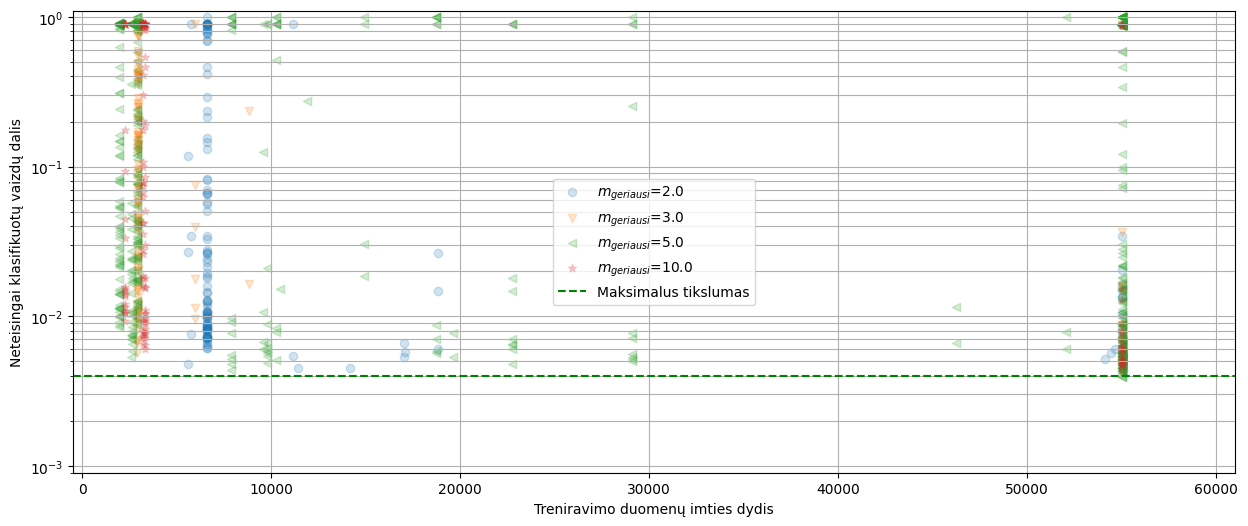

In [492]:
work_df = mnist_res_df.copy()
work_df = work_df.loc[work_df['filter_method'] == 'example_forgetting']
work_df.loc[work_df['ftk'].isna(), 'ftk'] = 5
# work_df['ftk'] = work_df['ftk'].astype(int)
# work_df = work_df.loc[~work_df['ftk'].isna()]
# work_df.loc[work_df['ftk'] == 2, 'ftk'] = 3
print(len(work_df))
print(pd.value_counts(work_df['ftk']))
print(sorted(pd.unique(work_df['ftk'])))

figure = plt.figure(figsize=(15, 6), clear=True)
plt.grid(True)

# plt.scatter(work_df['train_set_size'], 1 - work_df['test_acc'], alpha=0.2)

for ftk_value in sorted(pd.unique(work_df['ftk'])):
    ftk_df = work_df.loc[work_df['ftk'] == ftk_value]
    plt.scatter(ftk_df['train_set_size'], 1 - ftk_df['test_acc'], alpha=0.2, marker=MARKER_LIST[int(ftk_value)-2], label='$m_{geriausi}$=%s' % str(ftk_value))
    print(len(ftk_df))

plt.xlabel('Treniravimo duomenų imties dydis')
plt.ylabel('Neteisingai klasifikuotų vaizdų dalis')

plt.axhline(y=0.004, color='g', linestyle='--', label='Maksimalus tikslumas')

plt.ylim(0.0009, 1.1)
plt.yscale("log")
# plt.xscale("log")
plt.xlim(-500, 61000)

plt.grid(True, which='Minor')
# Add hline ties ~best acc

plt.legend()
plt.show()

In [450]:
250+139+124+113

626

#### CIFAR-10 LeNet3

In [459]:
lenet3_res_df = full_res_df.loc[full_res_df['experiment_type'] == 'CIFAR-10']
lenet3_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,root,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.011556,0.011197,3.0,32,64,112.0,80.0,472,elu,BatchNorm,1.0000,0.6863,151.0,45000.0,CIFAR-10,0,0,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.076464,0.526661,3.0,32,64,112.0,80.0,256,elu,None,0.0000,0.0000,0.0,45000.0,CIFAR-10,0,1,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001154,0.905991,2.0,24,64,120.0,80.0,480,elu,Dropout,0.1894,0.1912,16.0,45000.0,CIFAR-10,0,2,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005881,0.526295,2.0,16,40,80.0,112.0,968,tanh,BatchNorm,0.8038,0.6661,121.0,45000.0,CIFAR-10,0,3,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.137176,0.341528,3.0,24,56,72.0,104.0,456,tanh,BatchNorm,1.0000,0.7291,85.0,45000.0,CIFAR-10,0,4,\CIFAR-10-LeNet\1st-mato\1st_look_hardness-ucb...,1st_look_hardness,ucb,10.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.100000,1.000000,2.0,32,64,128.0,88.0,560,relu,BatchNorm,0.9516,0.6993,184.0,32563.0,CIFAR-10,68,95,\CIFAR-10-LeNet\min_agreggation-fix\example_fo...,example_forgetting,ucb,40.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,0.100000,1.000000,3.0,32,64,128.0,80.0,456,relu,None,0.0994,0.1001,13.0,32563.0,CIFAR-10,68,96,\CIFAR-10-LeNet\min_agreggation-fix\example_fo...,example_forgetting,ucb,40.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,0.100000,1.000000,2.0,32,40,104.0,128.0,448,relu,BatchNorm,0.9834,0.6959,174.0,32563.0,CIFAR-10,68,97,\CIFAR-10-LeNet\min_agreggation-fix\example_fo...,example_forgetting,ucb,40.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,0.100000,1.000000,2.0,32,40,64.0,128.0,456,relu,BatchNorm,0.9884,0.7005,175.0,32563.0,CIFAR-10,68,98,\CIFAR-10-LeNet\min_agreggation-fix\example_fo...,example_forgetting,ucb,40.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [461]:
print(pd.value_counts(lenet3_res_df['ftk']))
print(pd.unique(lenet3_res_df['ftk']))
print(pd.value_counts(lenet3_res_df['filter_method']))

3.0    500
5.0    400
2.0    396
Name: ftk, dtype: int64
[ 3.  5.  2. nan]
example_forgetting    1757
1st_look_hardness      617
Name: filter_method, dtype: int64


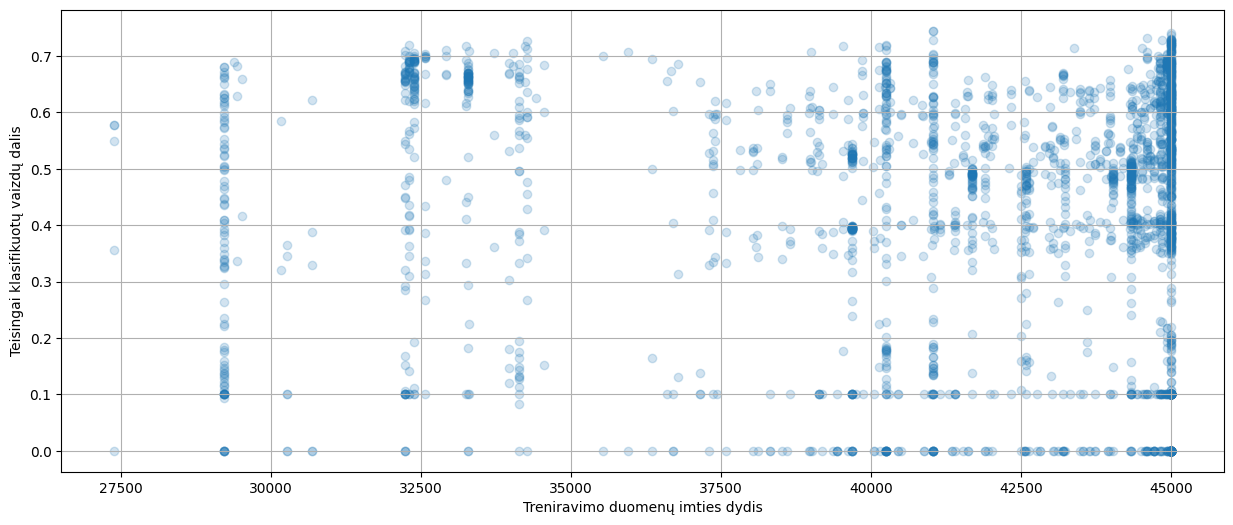

In [458]:
figure = plt.figure(figsize=(15, 6), clear=True)
plt.grid(True)

plt.scatter(lenet3_res_df['train_set_size'], lenet3_res_df['test_acc'], alpha=0.2)

plt.xlabel('Treniravimo duomenų imties dydis')
plt.ylabel('Teisingai klasifikuotų vaizdų dalis')

# plt.ylim(0.09, 1.1)
# plt.yscale("log")
# plt.xscale("log")

plt.grid(True, which='Minor')

plt.show()

### Time consumed vs train set size

In [64]:
from matplotlib.ticker import FormatStrFormatter

In [84]:
lenet1_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.000520,NaN,3.0,208,336,NaN,NaN,576,NaN,NaN,0.9998,0.9943,178.0,55000.0,MNIST-LeNet1,96,0,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.042754,3.0,2.0,0.393258,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000153,NaN,3.0,336,240,NaN,NaN,864,NaN,NaN,0.9992,0.9930,230.0,55000.0,MNIST-LeNet1,96,1,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.265040,2.0,3.0,0.686003,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014175,NaN,5.0,200,312,NaN,NaN,576,NaN,NaN,1.0000,0.9918,144.0,55000.0,MNIST-LeNet1,96,2,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.950638,3.0,3.0,0.901607,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005868,NaN,7.0,152,72,NaN,NaN,248,NaN,NaN,0.9988,0.9941,138.0,55000.0,MNIST-LeNet1,96,3,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.307111,3.0,3.0,0.276368,NaN,NaN,NaN,NaN,NaN,NaN
4,0.028110,NaN,3.0,312,280,NaN,NaN,48,NaN,NaN,0.9884,0.9864,244.0,55000.0,MNIST-LeNet1,96,4,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.126940,2.0,2.0,0.348266,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.043269,NaN,NaN,256,184,NaN,NaN,912,elu,NaN,0.9982,0.9925,211.0,19061.0,MNIST-LeNet2,148,82,1st_look_hardness,ucb,2.5,3.0,1,NaN,NaN,0.695868,NaN,NaN,0.873554,NaN,NaN,NaN,Adam,1.0,NaN
83,0.000104,NaN,NaN,184,152,NaN,NaN,224,relu,NaN,0.9388,0.9387,157.0,19061.0,MNIST-LeNet2,148,83,1st_look_hardness,ucb,2.5,3.0,1,NaN,NaN,0.609928,NaN,NaN,0.346549,NaN,NaN,NaN,AdaGrad,1.0,NaN
84,0.000309,NaN,NaN,112,112,NaN,NaN,208,elu,NaN,0.9652,0.9625,131.0,19061.0,MNIST-LeNet2,148,84,1st_look_hardness,ucb,2.5,3.0,1,NaN,NaN,0.841333,NaN,NaN,0.556698,NaN,NaN,NaN,AdaGrad,1.0,NaN
85,0.001077,NaN,NaN,296,144,NaN,NaN,912,lrelu,NaN,0.9896,0.9839,253.0,19061.0,MNIST-LeNet2,148,85,1st_look_hardness,ucb,2.5,3.0,1,NaN,NaN,0.803463,NaN,NaN,0.719261,NaN,NaN,NaN,AdaGrad,1.0,NaN


#### LeNet1

In [293]:
lenet1_res_df.loc[(lenet1_res_df['train_set_size'] > 54000) & (lenet1_res_df['train_set_size'] < 55000), 'train_set_size'] = 55000

In [294]:
print(lenet1_res_df.loc[lenet1_res_df['train_set_size'] > 50000, 'time_spent'].mean())
print(lenet1_res_df.loc[lenet1_res_df['train_set_size'] < 5000, 'time_spent'].mean())

202.59649122807016
20.190944881889763


1796.0 14.0
1950.0 19.617021276595743
1981.0 24.5
1986.0 21.180722891566266
2181.0 15.910112359550562
2294.0 22.238095238095237
2344.0 26.44943820224719
2578.0 18.88
2654.0 23.625
2897.0 14.210526315789474
3222.0 21.4
3232.0 14.1
3316.0 13.5
3318.0 22.555555555555557
5287.0 34.53125
5624.0 21.666666666666668
5756.0 20.0
5761.0 14.0
5963.0 25.166666666666668
7882.0 34.8
8850.0 132.0
8854.0 65.0
9382.0 20.0
9568.0 54.2
9779.0 39.2
10253.0 22.4
10489.0 26.0
10891.0 117.5
10939.0 89.28571428571429
11109.0 29.958333333333332
11157.0 30.5
11423.0 63.0
11918.0 40.0
14164.0 67.0
14927.0 22.5
15913.0 90.025
16543.0 58.885714285714286
17029.0 169.0
18746.0 46.8
19614.0 61.5
22771.0 82.3
29089.0 91.0
46210.0 232.5
52081.0 117.33333333333333
55000.0 203.5035460992908


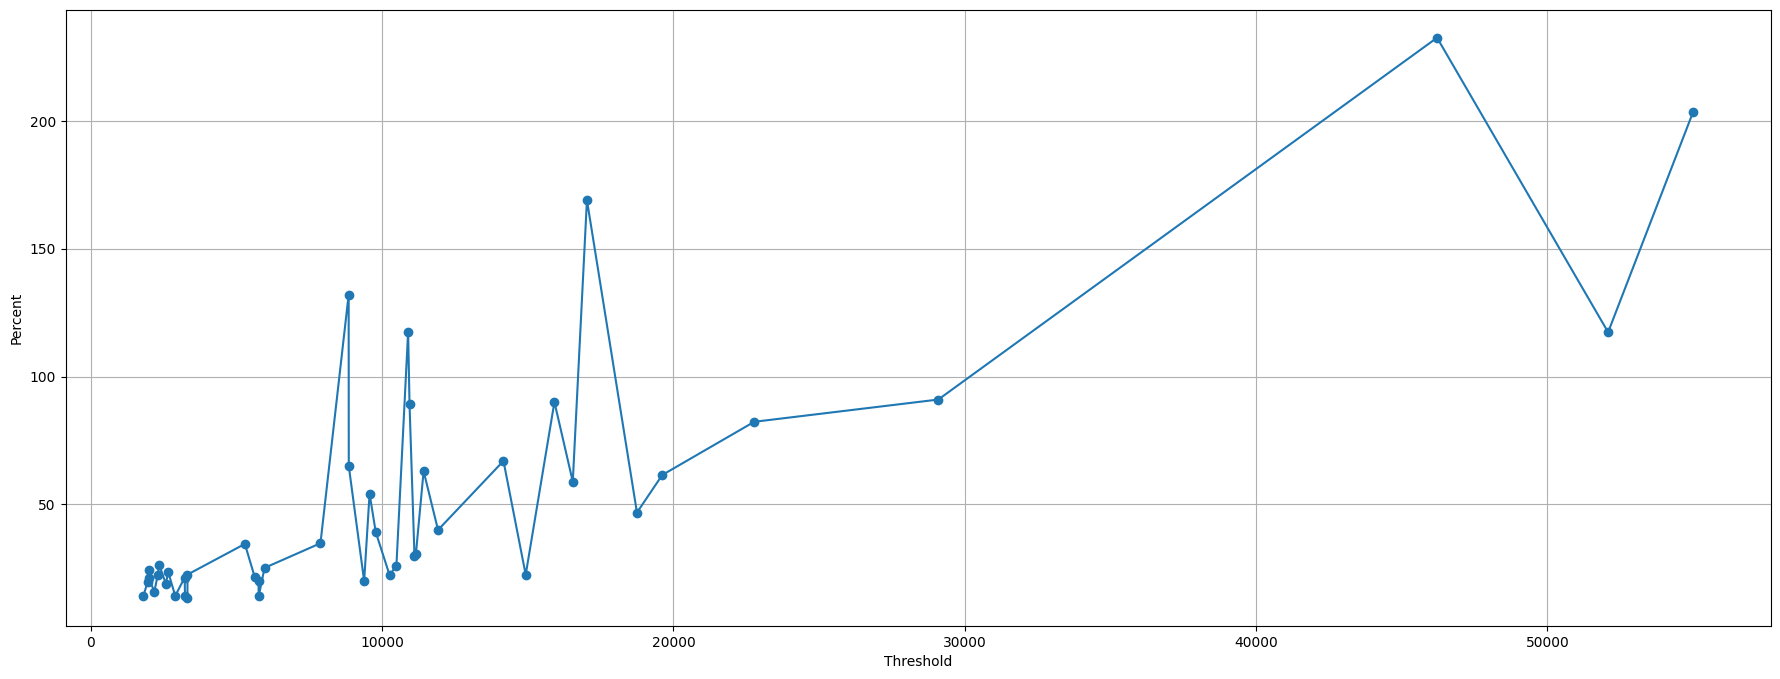

<Figure size 640x480 with 0 Axes>

In [295]:
timespans = []

train_set_sizes = sorted(pd.unique(lenet1_res_df['train_set_size']))

for train_set_size in train_set_sizes:
    train_set_size_df = lenet1_res_df.loc[lenet1_res_df['train_set_size'] == train_set_size]
    
    timespans.append(train_set_size_df['time_spent'].mean())
    print(train_set_size, train_set_size_df['time_spent'].mean())
    
plot_xy_curves(train_set_sizes, [timespans])

In [296]:
lenet1_res_df[['train_set_size', 'time_spent']].corr()

,train_set_size,time_spent
train_set_size,1.00000,0.61181
time_spent,0.61181,1.00000


In [298]:
lenet1_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.000520,NaN,3.0,208,336,NaN,NaN,576,NaN,NaN,0.9998,0.9943,178.0,55000.0,MNIST-LeNet1,96,0,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.042754,3.0,2.0,0.393258,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000153,NaN,3.0,336,240,NaN,NaN,864,NaN,NaN,0.9992,0.9930,230.0,55000.0,MNIST-LeNet1,96,1,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.265040,2.0,3.0,0.686003,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014175,NaN,5.0,200,312,NaN,NaN,576,NaN,NaN,1.0000,0.9918,144.0,55000.0,MNIST-LeNet1,96,2,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.950638,3.0,3.0,0.901607,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005868,NaN,7.0,152,72,NaN,NaN,248,NaN,NaN,0.9988,0.9941,138.0,55000.0,MNIST-LeNet1,96,3,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.307111,3.0,3.0,0.276368,NaN,NaN,NaN,NaN,NaN,NaN
4,0.028110,NaN,3.0,312,280,NaN,NaN,48,NaN,NaN,0.9884,0.9864,244.0,55000.0,MNIST-LeNet1,96,4,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.126940,2.0,2.0,0.348266,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,0.000498,NaN,7.0,88,224,NaN,NaN,312,NaN,NaN,0.9972,0.9932,28.0,2897.0,MNIST-LeNet1,141,21,example_forgetting,ucb,4.0,3.0,1,NaN,NaN,0.531366,2.0,3.0,0.427875,NaN,NaN,NaN,NaN,NaN,NaN
22,0.000598,NaN,4.0,64,208,NaN,NaN,336,NaN,NaN,0.9982,0.9904,17.0,2897.0,MNIST-LeNet1,141,22,example_forgetting,ucb,4.0,3.0,1,NaN,NaN,0.222070,2.0,2.0,0.900000,NaN,NaN,NaN,NaN,NaN,NaN
0,0.007693,NaN,4.0,160,136,NaN,NaN,248,NaN,NaN,0.5138,0.5408,161.0,55000.0,MNIST-LeNet1,142,0,example_forgetting,ucb,4.0,5.0,1,NaN,NaN,0.563896,2.0,3.0,0.036983,NaN,NaN,NaN,NaN,NaN,NaN
1,0.008767,NaN,5.0,240,120,NaN,NaN,504,NaN,NaN,0.9910,0.9898,214.0,55000.0,MNIST-LeNet1,142,1,example_forgetting,ucb,4.0,5.0,1,NaN,NaN,0.817292,2.0,3.0,0.199181,NaN,NaN,NaN,NaN,NaN,NaN


In [310]:
lenet1_res_df = lenet1_res_df.loc[~lenet1_res_df['ftk'].isna()]
lenet1_res_df = lenet1_res_df.loc[lenet1_res_df['ftk'] > 2]
lenet1_res_df

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.000520,NaN,3.0,208,336,NaN,NaN,576,NaN,NaN,0.9998,0.9943,178.0,55000.0,MNIST-LeNet1,96,0,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.042754,3.0,2.0,0.393258,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000153,NaN,3.0,336,240,NaN,NaN,864,NaN,NaN,0.9992,0.9930,230.0,55000.0,MNIST-LeNet1,96,1,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.265040,2.0,3.0,0.686003,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014175,NaN,5.0,200,312,NaN,NaN,576,NaN,NaN,1.0000,0.9918,144.0,55000.0,MNIST-LeNet1,96,2,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.950638,3.0,3.0,0.901607,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005868,NaN,7.0,152,72,NaN,NaN,248,NaN,NaN,0.9988,0.9941,138.0,55000.0,MNIST-LeNet1,96,3,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.307111,3.0,3.0,0.276368,NaN,NaN,NaN,NaN,NaN,NaN
4,0.028110,NaN,3.0,312,280,NaN,NaN,48,NaN,NaN,0.9884,0.9864,244.0,55000.0,MNIST-LeNet1,96,4,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.126940,2.0,2.0,0.348266,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,0.000498,NaN,7.0,88,224,NaN,NaN,312,NaN,NaN,0.9972,0.9932,28.0,2897.0,MNIST-LeNet1,141,21,example_forgetting,ucb,4.0,3.0,1,NaN,NaN,0.531366,2.0,3.0,0.427875,NaN,NaN,NaN,NaN,NaN,NaN
22,0.000598,NaN,4.0,64,208,NaN,NaN,336,NaN,NaN,0.9982,0.9904,17.0,2897.0,MNIST-LeNet1,141,22,example_forgetting,ucb,4.0,3.0,1,NaN,NaN,0.222070,2.0,2.0,0.900000,NaN,NaN,NaN,NaN,NaN,NaN
0,0.007693,NaN,4.0,160,136,NaN,NaN,248,NaN,NaN,0.5138,0.5408,161.0,55000.0,MNIST-LeNet1,142,0,example_forgetting,ucb,4.0,5.0,1,NaN,NaN,0.563896,2.0,3.0,0.036983,NaN,NaN,NaN,NaN,NaN,NaN
1,0.008767,NaN,5.0,240,120,NaN,NaN,504,NaN,NaN,0.9910,0.9898,214.0,55000.0,MNIST-LeNet1,142,1,example_forgetting,ucb,4.0,5.0,1,NaN,NaN,0.817292,2.0,3.0,0.199181,NaN,NaN,NaN,NaN,NaN,NaN


In [311]:
pd.value_counts(lenet1_res_df['ftk'])

10.0    413
3.0     339
5.0     150
Name: ftk, dtype: int64

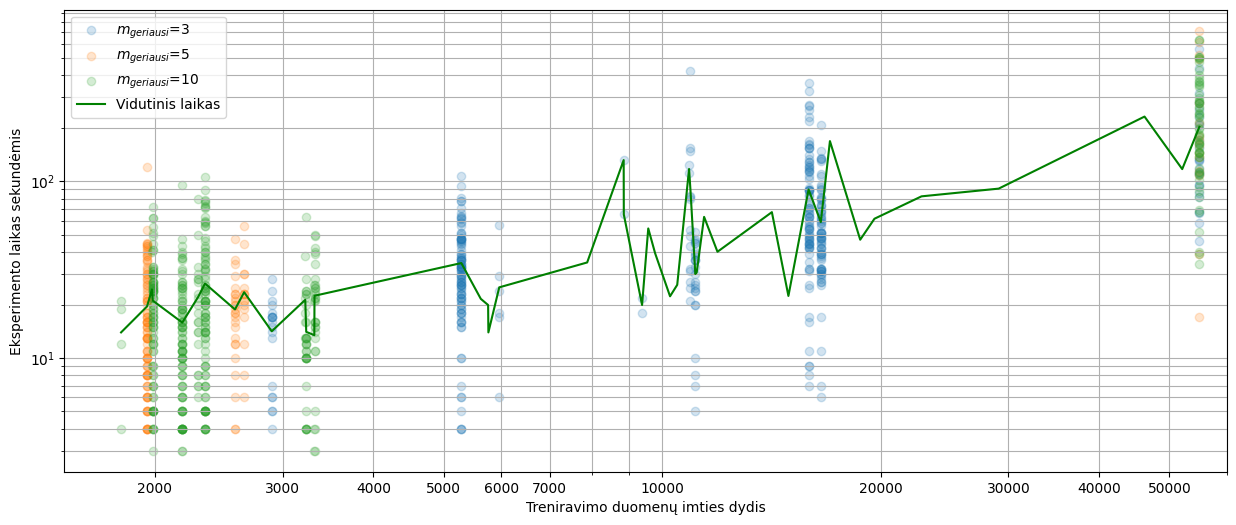

In [325]:
figure = plt.figure(figsize=(15, 6), clear=True)
plt.grid(True)

for ftk_value in pd.unique(lenet1_res_df['ftk']):
    plt.scatter(lenet1_res_df['train_set_size'],  lenet1_res_df['time_spent'], alpha=0.2, )

plt.plot(train_set_sizes, timespans, c='g', label='Vidutinis laikas')

plt.xlabel('Treniravimo duomenų imties dydis')
plt.ylabel('Eksperimento laikas sekundėmis')

plt.xlim(1500, 60000)
plt.yscale("log")
plt.xscale("log")

plt.grid(True, which='Minor')
x_ticks = [2000, 3000, 4000, 5000, 6000, 7000, 10000, 20000, 30000, 40000, 50000]
plt.xticks(x_ticks, x_ticks)

plt.legend()
plt.show()

#### LeNet3

In [198]:
lenet3_res_df = lenet3_res_df.loc[lenet3_res_df['train_set_size'] > 300]
# lenet3_res_df = lenet3_res_df.loc[lenet3_res_df['test_acc'] > 0]

In [200]:
lenet3_res_df['train_set_size'] = np.round(lenet3_res_df['train_set_size'], -2)

In [201]:
lenet3_res_df.loc[(lenet3_res_df['train_set_size'] > 54000) & (lenet3_res_df['train_set_size'] < 55000), 'train_set_size'] = 55000

In [211]:
print(lenet3_res_df.loc[lenet3_res_df['train_set_size'] > 40000, 'time_spent'].mean())
print(lenet3_res_df.loc[lenet3_res_df['train_set_size'] < 35000, 'time_spent'].mean())

190.112708453134
120.84224598930481


27400.0 197.4 5
29200.0 84.17045454545455 88
29400.0 146.0 4
29500.0 152.5 2
30200.0 275.0 2
30300.0 141.66666666666666 6
30700.0 129.4 5
32200.0 100.8 40
32300.0 124.84848484848484 33
32400.0 181.44444444444446 45
32600.0 139.0 14
32900.0 174.8 5
33300.0 123.94736842105263 57
33700.0 126.33333333333333 3
34000.0 102.2 10
34100.0 102.78125 32
34200.0 156.0 3
34300.0 122.46666666666667 15
34400.0 162.0 1
34500.0 126.5 4
35500.0 83.5 2
35900.0 68.0 2
36400.0 65.0 4
36600.0 98.5 2
36700.0 310.8333333333333 6
36800.0 111.0 3
37100.0 56.5 4
37300.0 275.6 5
37400.0 255.64705882352942 17
37600.0 226.8 5
37800.0 246.0 2
38000.0 215.33333333333334 6
38100.0 240.5 8
38300.0 123.6 5
38500.0 205.0 5
38600.0 191.6 5
38700.0 240.2 5
39000.0 171.78571428571428 14
39100.0 202.57142857142858 14
39200.0 173.6 5
39400.0 130.2 10
39500.0 59.666666666666664 6
39600.0 263.4 5
39700.0 434.5263157894737 76
39800.0 71.0 1
39900.0 177.36363636363637 11
40000.0 233.875 8
40100.0 140.0 10
40200.0 236.75 8
40300.0

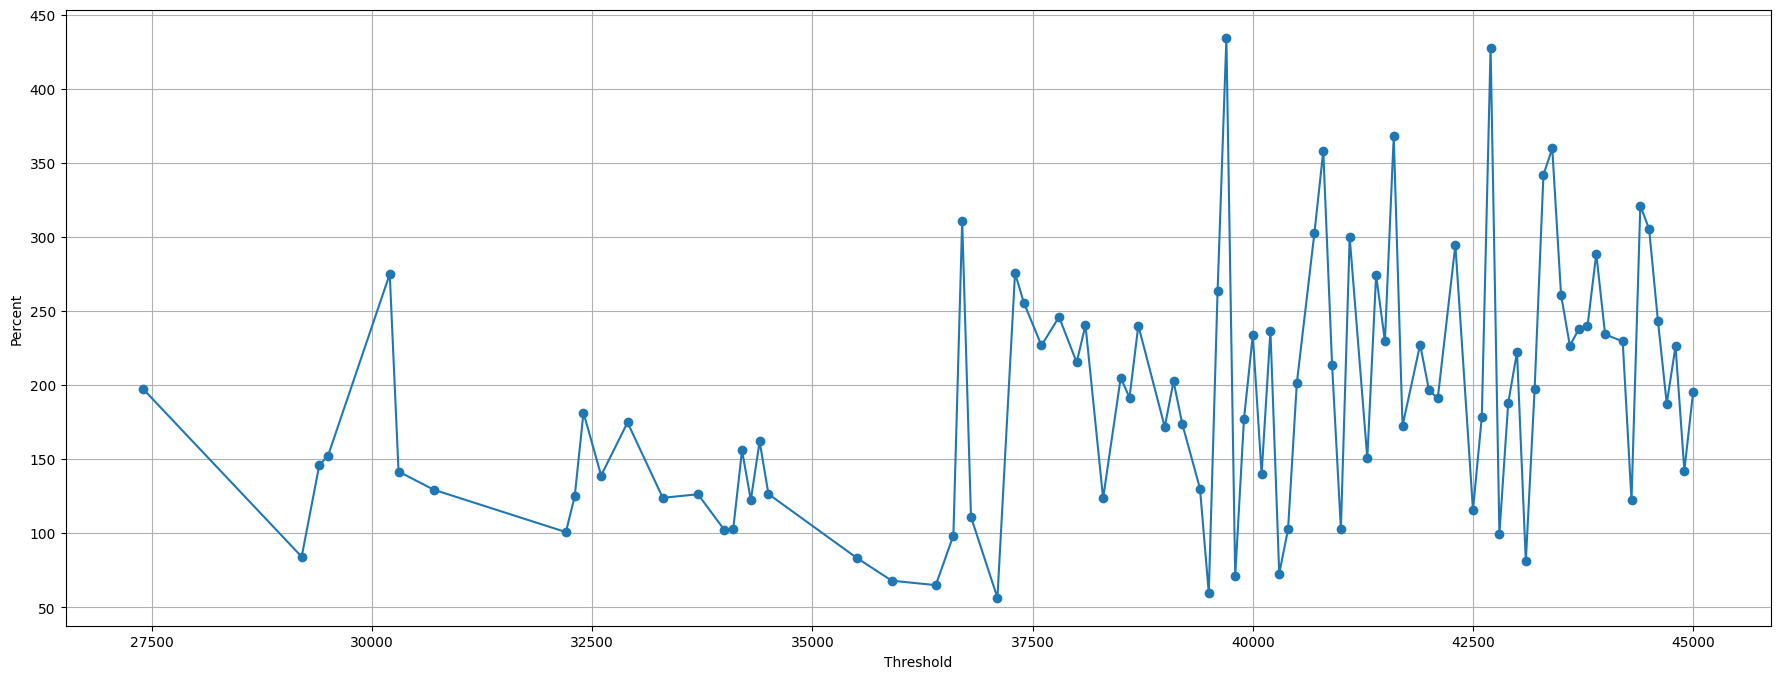

<Figure size 640x480 with 0 Axes>

In [209]:
timespans = []

train_set_sizes = sorted(pd.unique(lenet3_res_df['train_set_size']))

for train_set_size in train_set_sizes:
    train_set_size_df = lenet3_res_df.loc[lenet3_res_df['train_set_size'] == train_set_size]
    
    timespans.append(train_set_size_df['time_spent'].mean())
    print(train_set_size, train_set_size_df['time_spent'].mean(), len(train_set_size_df))
    
plot_xy_curves(train_set_sizes, [timespans])

In [216]:
lenet3_res_df[['train_set_size', 'time_spent']].corr()

,train_set_size,time_spent
train_set_size,1.000000,0.165597
time_spent,0.165597,1.000000


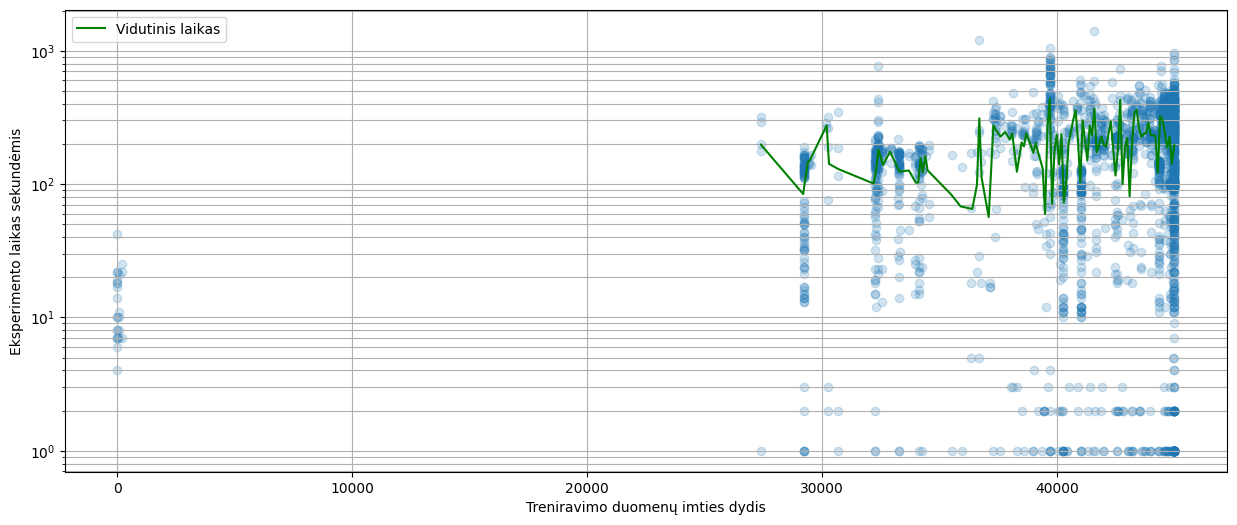

In [292]:
figure = plt.figure(figsize=(15, 6), clear=True)
plt.grid(True)

plt.scatter(lenet3_res_df['train_set_size'],  lenet3_res_df['time_spent'], alpha=0.2)
plt.plot(train_set_sizes, timespans, c='g', label='Vidutinis laikas')

plt.xlabel('Treniravimo duomenų imties dydis')
plt.ylabel('Eksperimento laikas sekundėmis')

# plt.xlim(1500, 60000)
plt.yscale("log")
# plt.xscale("log")

plt.grid(True, which='Minor')
# x_ticks = [2000, 3000, 4000, 5000, 6000, 7000, 10000, 20000, 30000, 40000, 50000]
# plt.xticks(x_ticks, x_ticks)

plt.legend()
plt.show()

### ftk vs train set size

In [233]:
lenet1_res_df.loc[~lenet1_res_df['ftk'].isna()]

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size,experiment_type,exp_index,run_idx,filter_method,acquisition,k,ftk,repetition,ff,fq,reg_param,pool1_size,pool2_size,dropout_rate,1,2,4,optimizer,batch_normalization,50
0,0.000520,NaN,3.0,208,336,NaN,NaN,576,NaN,NaN,0.9998,0.9943,178.0,55000.0,MNIST-LeNet1,96,0,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.042754,3.0,2.0,0.393258,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000153,NaN,3.0,336,240,NaN,NaN,864,NaN,NaN,0.9992,0.9930,230.0,55000.0,MNIST-LeNet1,96,1,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.265040,2.0,3.0,0.686003,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014175,NaN,5.0,200,312,NaN,NaN,576,NaN,NaN,1.0000,0.9918,144.0,55000.0,MNIST-LeNet1,96,2,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.950638,3.0,3.0,0.901607,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005868,NaN,7.0,152,72,NaN,NaN,248,NaN,NaN,0.9988,0.9941,138.0,55000.0,MNIST-LeNet1,96,3,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.307111,3.0,3.0,0.276368,NaN,NaN,NaN,NaN,NaN,NaN
4,0.028110,NaN,3.0,312,280,NaN,NaN,48,NaN,NaN,0.9884,0.9864,244.0,55000.0,MNIST-LeNet1,96,4,1st_look_hardness,ucb,1.0,10.0,1,NaN,NaN,0.126940,2.0,2.0,0.348266,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,0.000498,NaN,7.0,88,224,NaN,NaN,312,NaN,NaN,0.9972,0.9932,28.0,2897.0,MNIST-LeNet1,141,21,example_forgetting,ucb,4.0,3.0,1,NaN,NaN,0.531366,2.0,3.0,0.427875,NaN,NaN,NaN,NaN,NaN,NaN
22,0.000598,NaN,4.0,64,208,NaN,NaN,336,NaN,NaN,0.9982,0.9904,17.0,2897.0,MNIST-LeNet1,141,22,example_forgetting,ucb,4.0,3.0,1,NaN,NaN,0.222070,2.0,2.0,0.900000,NaN,NaN,NaN,NaN,NaN,NaN
0,0.007693,NaN,4.0,160,136,NaN,NaN,248,NaN,NaN,0.5138,0.5408,161.0,55000.0,MNIST-LeNet1,142,0,example_forgetting,ucb,4.0,5.0,1,NaN,NaN,0.563896,2.0,3.0,0.036983,NaN,NaN,NaN,NaN,NaN,NaN
1,0.008767,NaN,5.0,240,120,NaN,NaN,504,NaN,NaN,0.9910,0.9898,214.0,55000.0,MNIST-LeNet1,142,1,example_forgetting,ucb,4.0,5.0,1,NaN,NaN,0.817292,2.0,3.0,0.199181,NaN,NaN,NaN,NaN,NaN,NaN


Depreciated, use calculate_CED
ftk=2.0 | size: 24 | test_acc: 0.8748
Depreciated, use calculate_CED
ftk=3.0 | size: 339 | test_acc: 0.8386
Depreciated, use calculate_CED
ftk=5.0 | size: 150 | test_acc: 0.6495
Depreciated, use calculate_CED
ftk=10.0 | size: 413 | test_acc: 0.5349


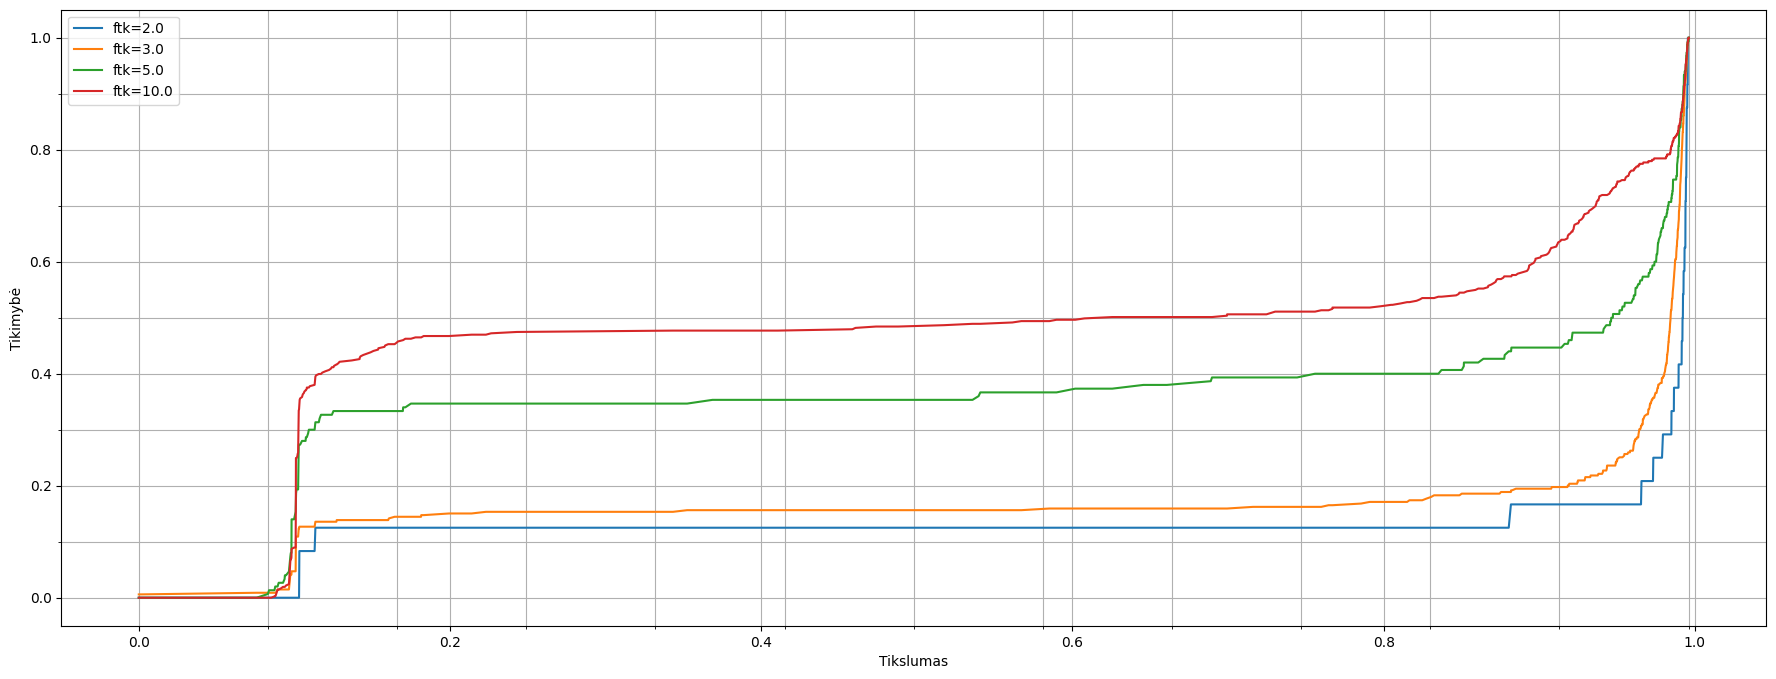

{2.0: 0.8748458333333334,
 3.0: 0.8386014749262538,
 5.0: 0.649522,
 10.0: 0.5349113801452785}

<Figure size 640x480 with 0 Axes>

In [269]:
categorical_metric_analysis(lenet1_res_df.sort_values('ftk'), ['ftk'], 'test_acc', True, False, log_scale=False)

Depreciated, use calculate_CED
ftk=2.0 | size: 24 | train_set_size: 0.5866
Depreciated, use calculate_CED
ftk=3.0 | size: 339 | train_set_size: 0.2589
Depreciated, use calculate_CED
ftk=5.0 | size: 150 | train_set_size: 0.1352
Depreciated, use calculate_CED
ftk=10.0 | size: 413 | train_set_size: 0.1800


<ipython-input-288-b68b10cc0ab3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lenet1_res_df['train_set_size'] = lenet1_res_df['train_set_size'] / lenet1_res_df['train_set_size'].max()


{2.0: 0.586605303030303,
 3.0: 0.2589131134352374,
 5.0: 0.13517745454545452,
 10.0: 0.17996051067576493}

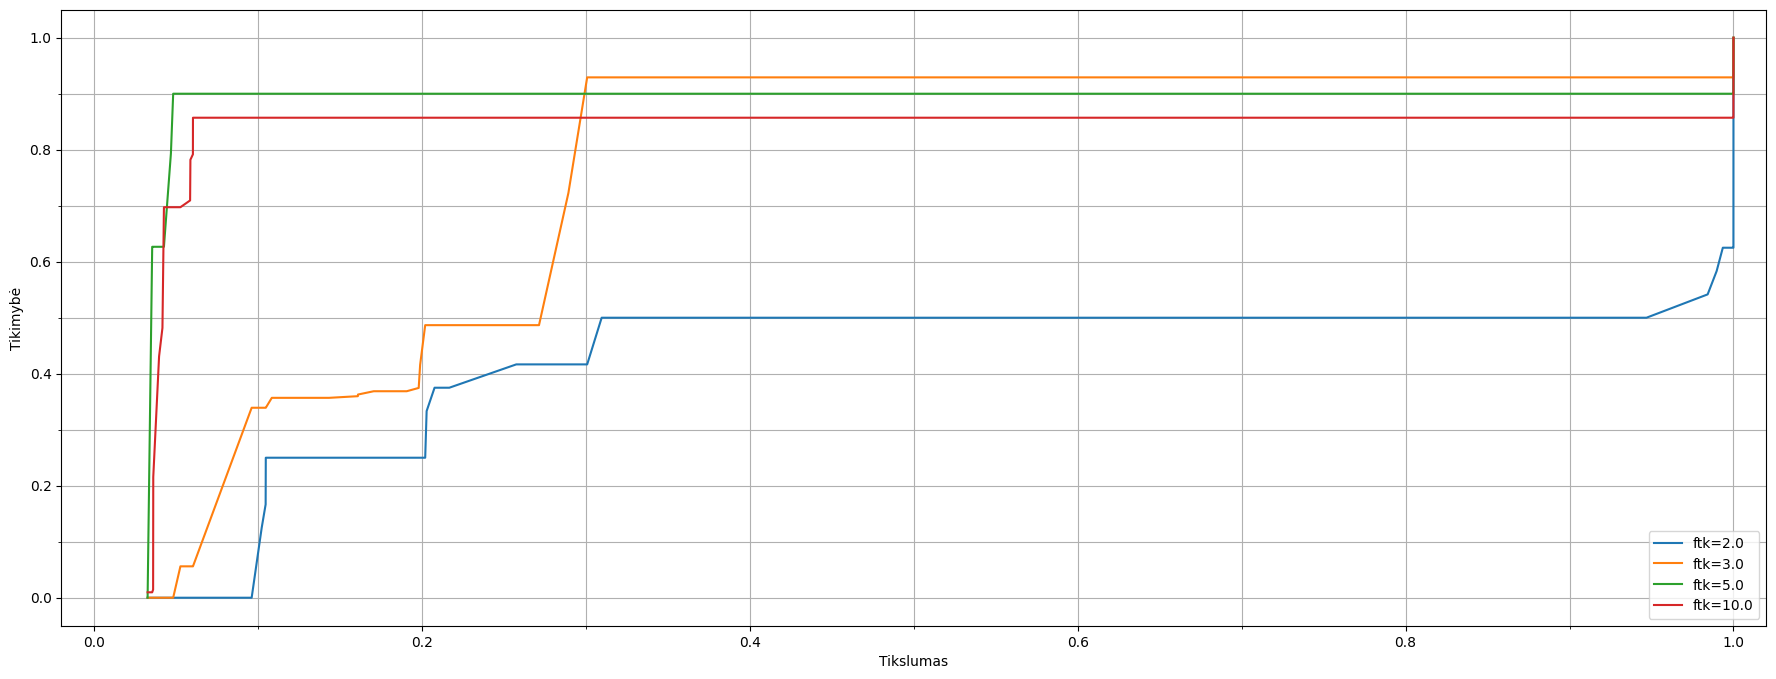

In [288]:
lenet1_res_df['train_set_size'] = lenet1_res_df['train_set_size'] / lenet1_res_df['train_set_size'].max()

categorical_metric_analysis(lenet1_res_df.sort_values('ftk'), ['ftk'], 'train_set_size', True, False)

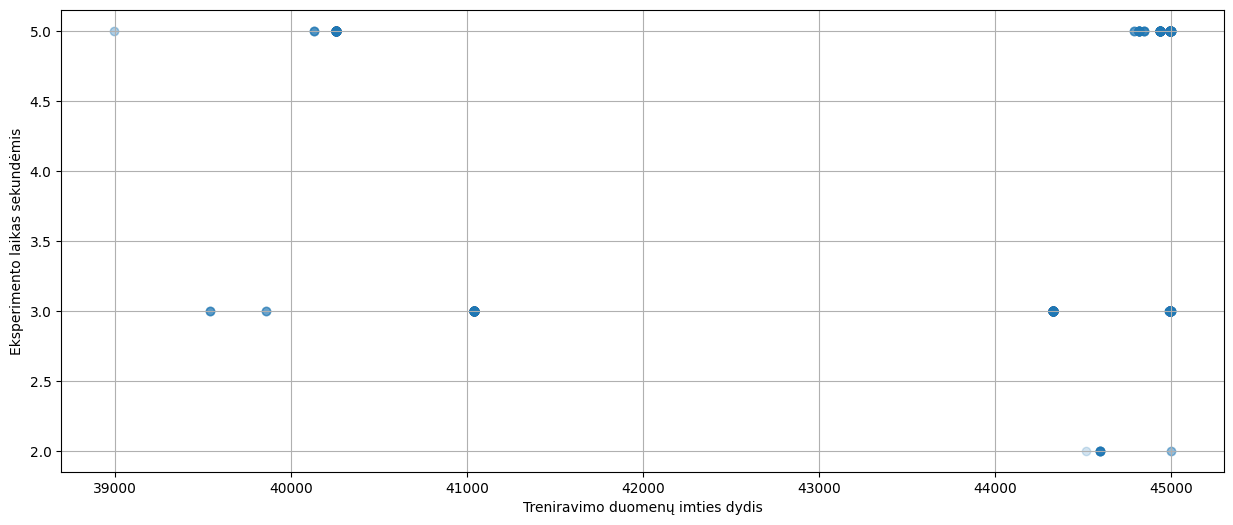

In [67]:
figure = plt.figure(figsize=(15, 6), clear=True)
plt.grid(True)

plt.scatter(lenet3_res_df['train_set_size'],  lenet3_res_df['ftk'], alpha=0.2)

plt.xlabel('Treniravimo duomenų imties dydis')
plt.ylabel('Eksperimento laikas sekundėmis')

plt.show()